In [ ]:
# Data handling and numerical operations
import pandas as pd
import numpy as np
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
# Dimensionality reduction and feature selection
from sklearn.decomposition import PCA
from sklearn.linear_model import LassoCV
# Model explanation
import shap
# Classifiers
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
# Data preprocessing and scaling
from sklearn.preprocessing import StandardScaler
# Model training and hyperparameter tuning
from sklearn.model_selection import train_test_split, GridSearchCV
# Evaluation metrics
from sklearn.metrics import accuracy_score, classification_report
# Model saving/loading
import joblib


In [ ]:
# File paths for the datasets
train_quantitative_path = "/content/TRAIN_QUANTITATIVE_METADATA_new.xlsx"
train_categorical_path = "/content/TRAIN_CATEGORICAL_METADATA_new.xlsx"
test_quantitative_path = "/content/TEST_QUANTITATIVE_METADATA.xlsx"
test_categorical_path = "/content/TEST_CATEGORICAL.xlsx"
labels_path = "/content/TRAINING_SOLUTIONS.xlsx"
train_connectome_path="/content/TRAIN_FUNCTIONAL_CONNECTOME_MATRICES_new_36P_Pearson (1).csv"
test_connectome_path="/content/TEST_FUNCTIONAL_CONNECTOME_MATRICES (1).csv"

In [ ]:
# Load all training/testing data, labels, and connectome matrices into DataFrames
train_quantitative_df = pd.read_excel(train_quantitative_path)
train_categorical_df = pd.read_excel(train_categorical_path)
test_quantitative_df = pd.read_excel(test_quantitative_path)
test_categorical_df = pd.read_excel(test_categorical_path)
labels_df = pd.read_excel(labels_path)
train_connectome_df=pd.read_csv(train_connectome_path)
test_connectome_df=pd.read_csv(test_connectome_path)

In [ ]:
# Merge all training and test datasets on 'participant_id' to create unified DataFrames
train_df = (pd.merge(train_quantitative_df, train_categorical_df, on='participant_id', how='inner')
              .merge(train_connectome_df, on='participant_id', how='inner')
              .merge(labels_df, on='participant_id', how='inner'))


test_df = (pd.merge(test_quantitative_df, test_categorical_df, on='participant_id', how='inner')
             .merge(test_connectome_df, on='participant_id', how='inner'))


In [ ]:
train_df.shape

(1213, 19930)

In [ ]:
test_df.shape

(304, 19928)

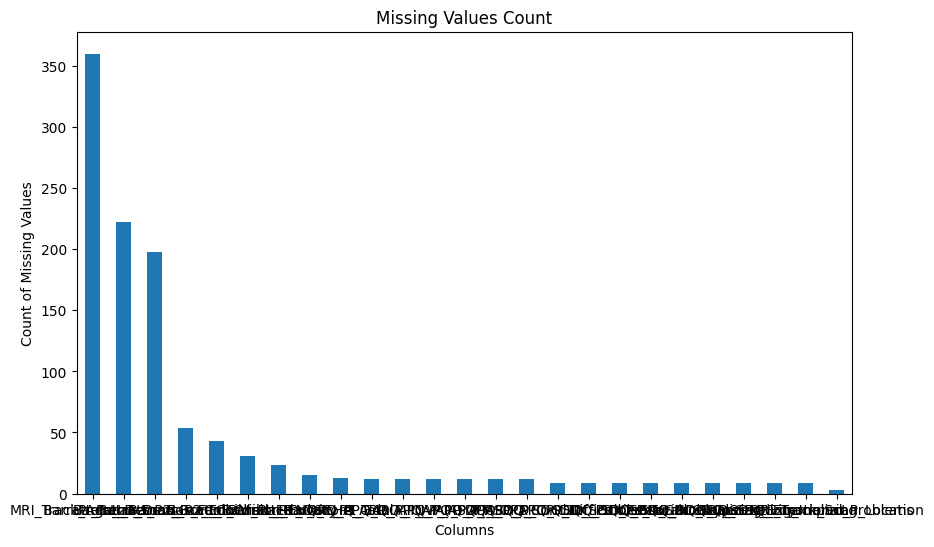

In [ ]:
# Visualize missing values
missing_values = train_df.isnull().sum()
missing_values = missing_values[missing_values > 0]
plt.figure(figsize=(10, 6))
missing_values.sort_values(ascending=False).plot(kind='bar')
plt.title('Missing Values Count')
plt.xlabel('Columns')
plt.ylabel('Count of Missing Values')
plt.xticks(rotation=0)
plt.show()


In [ ]:
# Impute missing values in train_df: mode for categorical, mean/median for numeric based on skewness

import numpy as np
from scipy import stats

def impute_missing_data_inplace(df):
    """Impute missing values directly in the passed DataFrame"""
    # 1. Handle categorical columns - mode imputation
    cat_cols = df.select_dtypes(include=['object', 'category']).columns
    for col in cat_cols:
        if df[col].isnull().sum() > 0:  # Check if there are missing values
            mode_val = df[col].mode()[0]
            print(f"Imputing missing values in column {col} with mode: {mode_val}")
            df[col] = df[col].fillna(mode_val)  # Assign back to avoid FutureWarning
        else:
            print(f"No missing values in column {col}. Mode imputation not needed.")

    # 2. Handle numerical columns
    num_cols = df.select_dtypes(include=np.number).columns

    for col in num_cols:
        if df[col].isnull().sum() > 0:
            col_skew = stats.skew(df[col].dropna())  # Use stats.skew from scipy

            if abs(col_skew) > 1:
                median_val = df[col].median()
                df[col] = df[col].fillna(median_val)  # Assign back to avoid FutureWarning
                print(f"Skewed column {col} (skew={col_skew:.2f}) imputed with median: {median_val:.2f}")
            else:
                mean_val = df[col].mean()
                df[col] = df[col].fillna(mean_val)  # Assign back to avoid FutureWarning
                print(f"Normal column {col} (skew={col_skew:.2f}) imputed with mean: {mean_val:.2f}")

# Apply directly to train_df
impute_missing_data_inplace(train_df)
print("\nMissing values after imputation:", train_df.isnull().sum().sum())


No missing values in column participant_id. Mode imputation not needed.
Skewed column EHQ_EHQ_Total (skew=-1.67) imputed with median: 77.80
Skewed column ColorVision_CV_Score (skew=-4.98) imputed with median: 14.00
Skewed column APQ_P_APQ_P_CP (skew=1.90) imputed with median: 3.00
Normal column APQ_P_APQ_P_ID (skew=0.16) imputed with mean: 13.34
Normal column APQ_P_APQ_P_INV (skew=-0.24) imputed with mean: 39.77
Normal column APQ_P_APQ_P_OPD (skew=0.04) imputed with mean: 17.96
Normal column APQ_P_APQ_P_PM (skew=0.90) imputed with mean: 16.56
Normal column APQ_P_APQ_P_PP (skew=-0.52) imputed with mean: 25.50
Normal column SDQ_SDQ_Conduct_Problems (skew=1.00) imputed with mean: 2.07
Normal column SDQ_SDQ_Difficulties_Total (skew=0.32) imputed with mean: 12.21
Normal column SDQ_SDQ_Emotional_Problems (skew=0.93) imputed with mean: 2.32
Normal column SDQ_SDQ_Externalizing (skew=0.19) imputed with mean: 7.61
Normal column SDQ_SDQ_Generating_Impact (skew=0.16) imputed with mean: 4.10
Normal

In [ ]:
# Print any remaining missing values
print("\nRemaining Missing Values in Train:\n", train_df.isnull().sum().sum())
print("Remaining Missing Values in Test:\n", test_df.isnull().sum().sum())


Remaining Missing Values in Train:
 0
Remaining Missing Values in Test:
 459


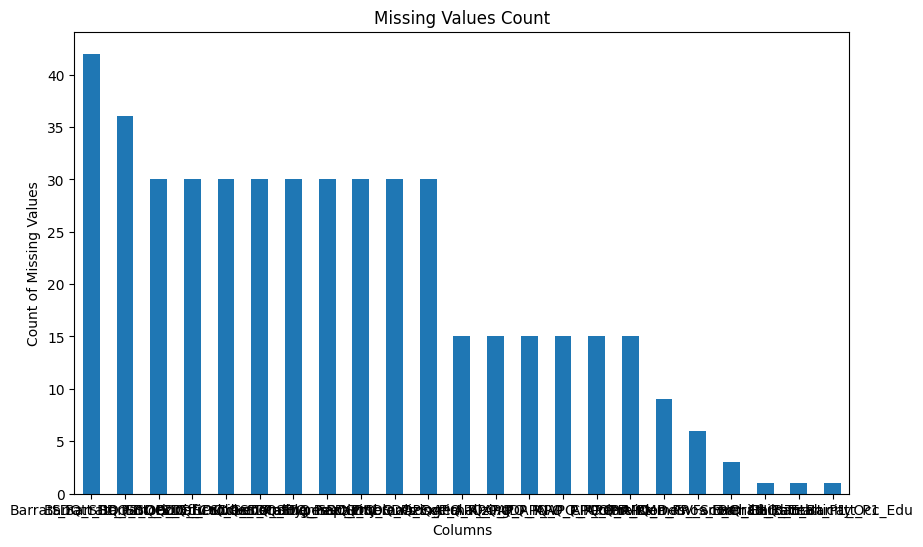

In [ ]:
# Visualize missing values
missing_values = test_df.isnull().sum()
missing_values = missing_values[missing_values > 0]
plt.figure(figsize=(10, 6))
missing_values.sort_values(ascending=False).plot(kind='bar')
plt.title('Missing Values Count')
plt.xlabel('Columns')
plt.ylabel('Count of Missing Values')
plt.xticks(rotation=0)
plt.show()



In [ ]:
# Impute missing values in test_df: mode for categorical, mean/median for numeric (based on skewness)

import pandas as pd
import numpy as np
from scipy.stats import skew

def impute_test_data(test_df):
    """
    Impute missing values DIRECTLY in test_df (no train data involved)
    - Categorical: Mode from test data
    - Numerical: Mean/median based on test data's own skewness
    - Modifies test_df in-place
    """
    print("=== Test Data Imputation ===")

    # 1. Handle categorical columns (mode imputation)
    cat_cols = test_df.select_dtypes(include=['object', 'category']).columns
    for col in cat_cols:
        if test_df[col].isna().any():
            # Handle cases where mode() might be empty
            mode_val = test_df[col].mode()[0] if not test_df[col].mode().empty else "Unknown"
            test_df[col].fillna(mode_val, inplace=True)
            print(f"[Categorical] {col}: filled with mode = {mode_val}")

    # 2. Handle numerical columns (mean/median based on skewness)
    num_cols = test_df.select_dtypes(include=np.number).columns
    for col in num_cols:
        if test_df[col].isna().any():
            # Calculate skewness using only non-null values
            valid_vals = test_df[col].dropna()

            if len(valid_vals) > 0:  # If we have values to analyze
                col_skew = skew(valid_vals)
                if abs(col_skew) > 1:
                    fill_val = test_df[col].median()
                    strategy = "median"
                else:
                    fill_val = test_df[col].mean()
                    strategy = "mean"
            else:  # Entire column is NA
                fill_val = 0
                strategy = "0 (all NA)"

            test_df[col].fillna(fill_val, inplace=True)
            print(f"[Numerical] {col}: filled with {strategy} = {fill_val:.2f}")

    # 3. Final check for remaining NAs
    remaining_missing = test_df.isna().sum().sum()
    if remaining_missing > 0:
        print(f"\nWarning: {remaining_missing} missing values remain after imputation!")
        print("Applying fallback imputation with 0 (numeric) or 'Unknown' (categorical)")

        for col in test_df.columns:
            if test_df[col].isna().any():
                fill_val = 0 if np.issubdtype(test_df[col].dtype, np.number) else "Unknown"
                test_df[col].fillna(fill_val, inplace=True)
                print(f"[Fallback] {col}: filled with {fill_val}")

    print("\nImputation complete. Modified test_df directly.")
    return test_df  # Return reference (though modifications are already in-place)

# Usage:
impute_test_data(test_df)  # Modifies test_df directly

# Verify:
print("\nMissing values in test_df after imputation:", test_df.isna().sum().sum())
print("Columns with missing values:", test_df.columns[test_df.isna().any()].tolist())

=== Test Data Imputation ===
[Numerical] EHQ_EHQ_Total: filled with median = 73.37
[Numerical] ColorVision_CV_Score: filled with median = 14.00
[Numerical] APQ_P_APQ_P_CP: filled with median = 3.00
[Numerical] APQ_P_APQ_P_ID: filled with mean = 13.26
[Numerical] APQ_P_APQ_P_INV: filled with mean = 39.63
[Numerical] APQ_P_APQ_P_OPD: filled with mean = 16.73
[Numerical] APQ_P_APQ_P_PM: filled with mean = 15.94
[Numerical] APQ_P_APQ_P_PP: filled with mean = 24.83
[Numerical] SDQ_SDQ_Conduct_Problems: filled with median = 1.00
[Numerical] SDQ_SDQ_Difficulties_Total: filled with mean = 11.78
[Numerical] SDQ_SDQ_Emotional_Problems: filled with mean = 2.39
[Numerical] SDQ_SDQ_Externalizing: filled with mean = 7.47
[Numerical] SDQ_SDQ_Generating_Impact: filled with mean = 3.95
[Numerical] SDQ_SDQ_Hyperactivity: filled with mean = 5.58
[Numerical] SDQ_SDQ_Internalizing: filled with mean = 4.31
[Numerical] SDQ_SDQ_Peer_Problems: filled with median = 1.00
[Numerical] SDQ_SDQ_Prosocial: filled wit

<ipython-input-8-864819813>:42: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_df[col].fillna(fill_val, inplace=True)



Imputation complete. Modified test_df directly.

Missing values in test_df after imputation: 0
Columns with missing values: []


In [ ]:
# Print any remaining missing values
print("\nRemaining Missing Values in Train:\n", train_df.isnull().sum().sum())
print("Remaining Missing Values in Test:\n", test_df.isnull().sum().sum())
test_df.shape


Remaining Missing Values in Train:
 0
Remaining Missing Values in Test:
 0


(304, 19928)

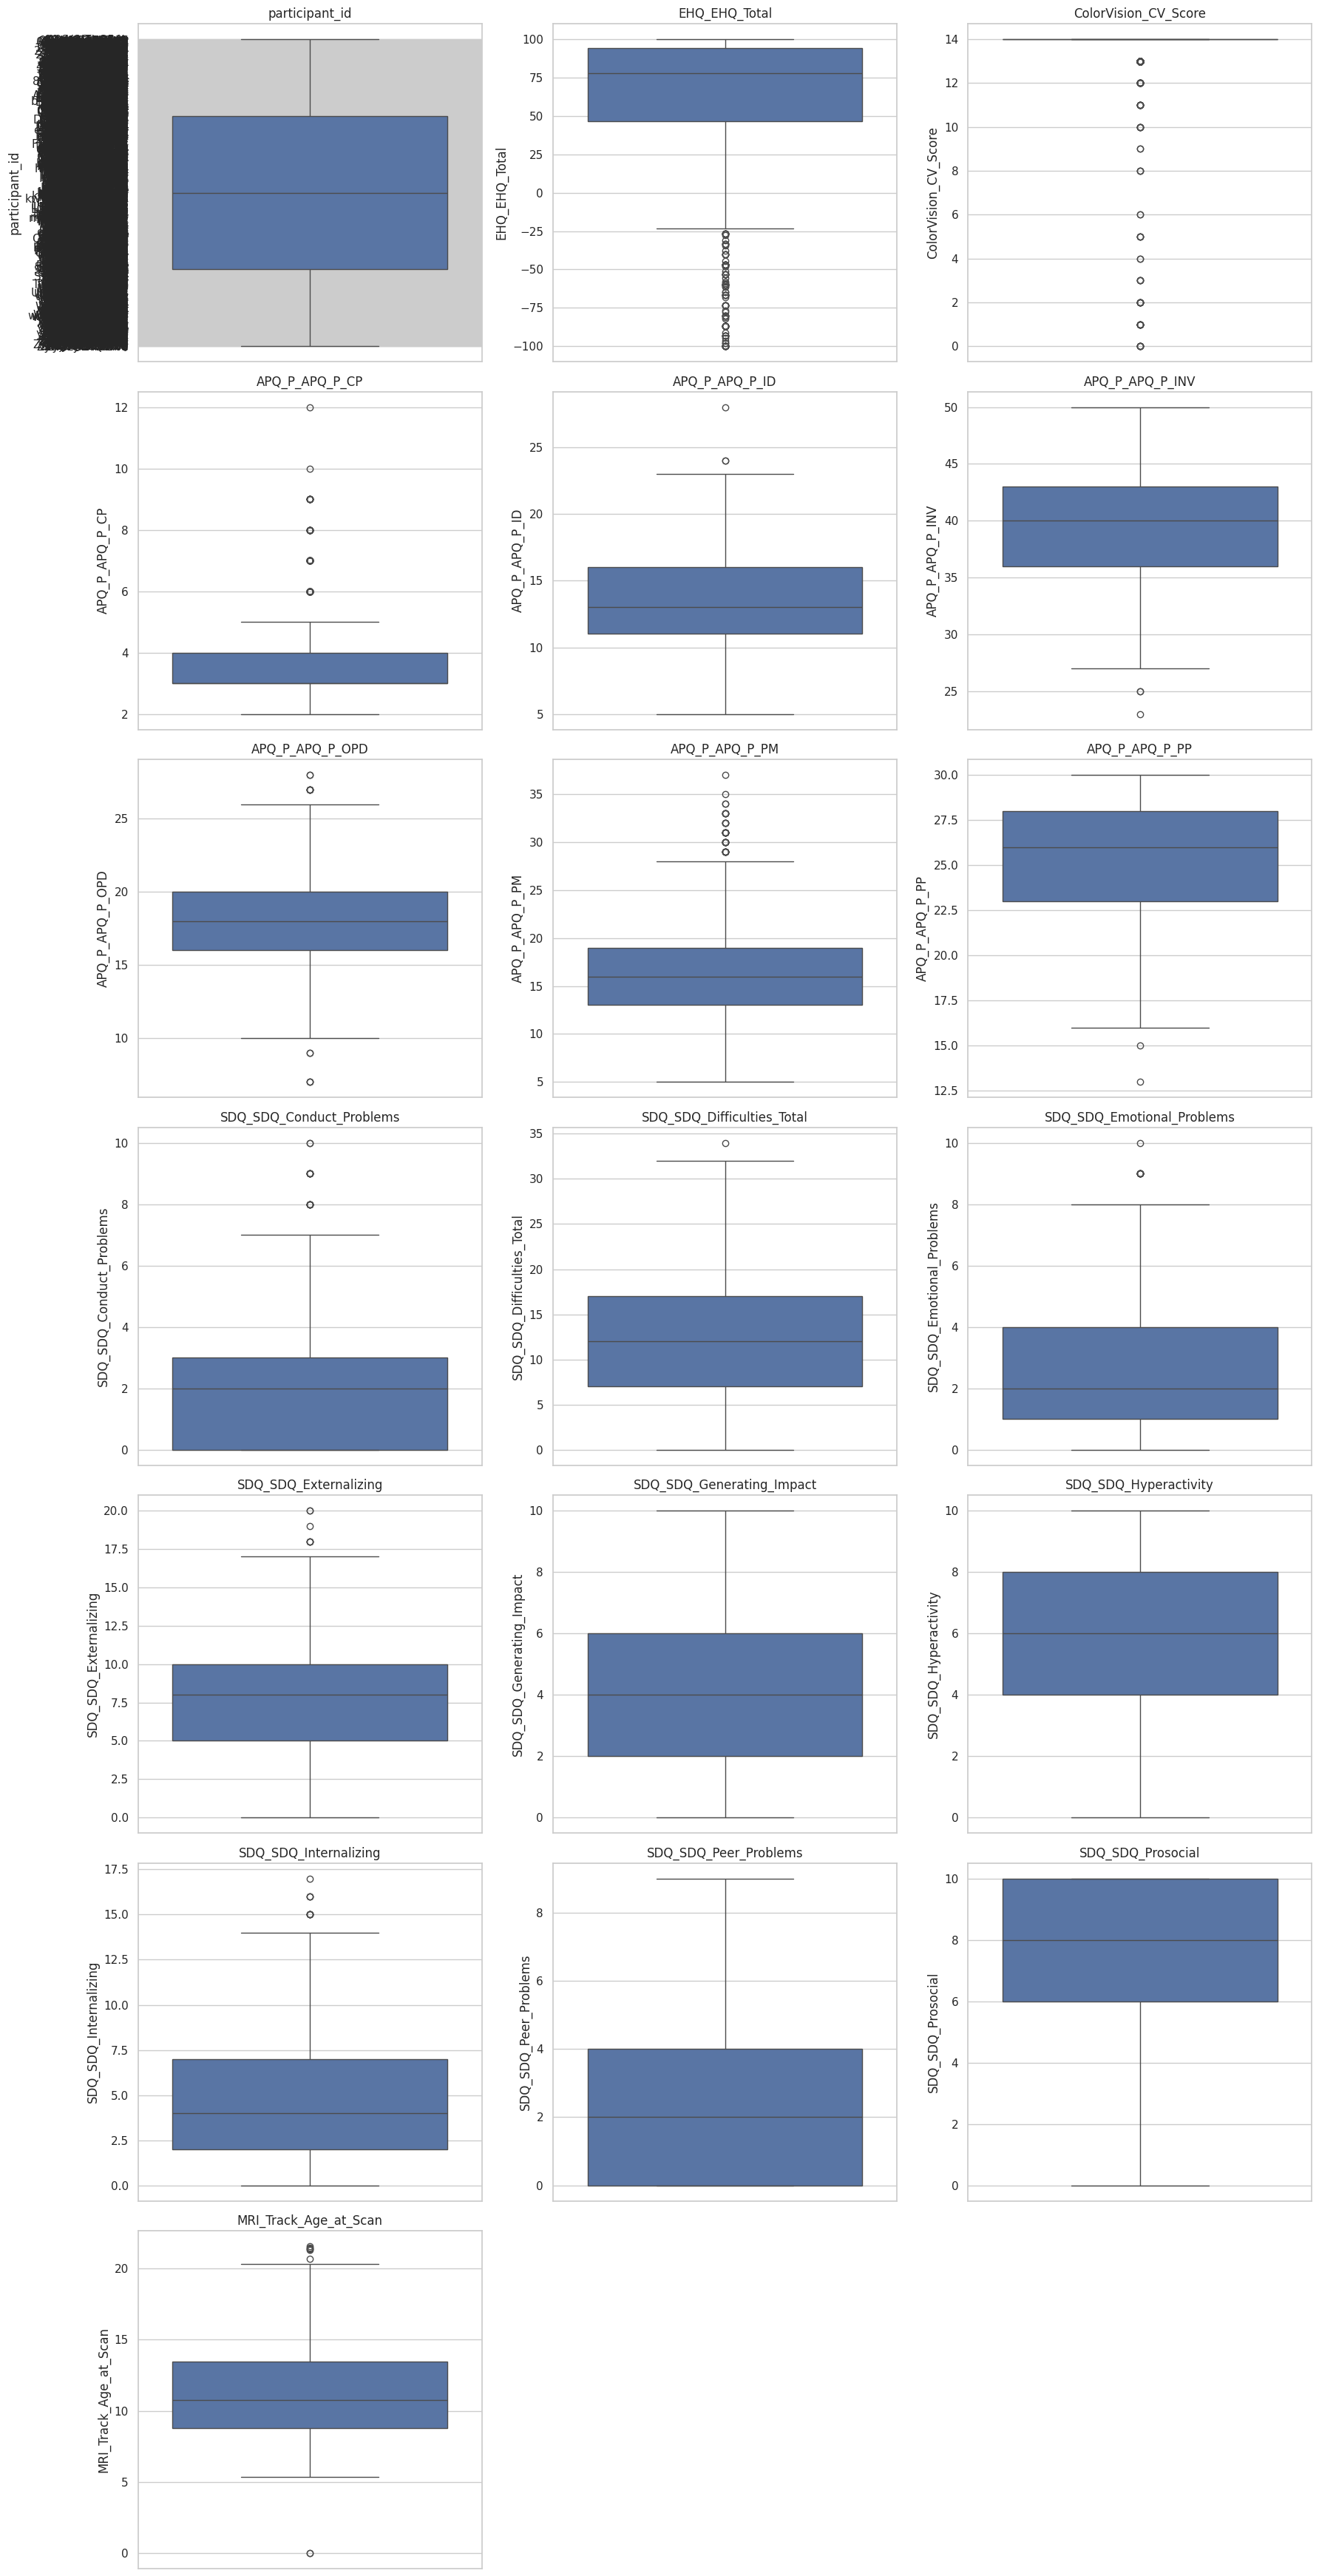

In [ ]:
# Plot boxplots for each quantitative feature in train data to visualize distributions and outliers

sns.set(style="whitegrid")
n_cols = 3
n_rows = (len(train_quantitative_df.columns) + n_cols - 1) // n_cols

plt.figure(figsize=(n_cols * 6, n_rows * 5))

for index, column in enumerate(train_quantitative_df.columns):
    plt.subplot(n_rows, n_cols, index + 1)
    sns.boxplot(y=train_quantitative_df[column])
    plt.title(column)
    plt.tight_layout()

plt.show()

In [ ]:
import pandas as pd



# Dictionary to store number of outliers per column
outlier_counts = {}

# Select only numeric columns
numeric_cols = train_quantitative_df.select_dtypes(include='number').columns

# Loop through numeric columns and compute outliers using IQR method
for column in numeric_cols:
    Q1 = train_quantitative_df[column].quantile(0.25)
    Q3 = train_quantitative_df[column].quantile(0.75)
    IQR = Q3 - Q1

    # Detect outliers
    outliers = train_quantitative_df[
        (train_quantitative_df[column] < (Q1 - 1.5 * IQR)) |
        (train_quantitative_df[column] > (Q3 + 1.5 * IQR))
    ]

    # Store count of outliers
    outlier_counts[column] = outliers.shape[0]

# Print outlier counts
for column, count in outlier_counts.items():
    print(f"{column}: {count} outliers")


EHQ_EHQ_Total: 110 outliers
ColorVision_CV_Score: 221 outliers
APQ_P_APQ_P_CP: 127 outliers
APQ_P_APQ_P_ID: 3 outliers
APQ_P_APQ_P_INV: 3 outliers
APQ_P_APQ_P_OPD: 13 outliers
APQ_P_APQ_P_PM: 37 outliers
APQ_P_APQ_P_PP: 2 outliers
SDQ_SDQ_Conduct_Problems: 17 outliers
SDQ_SDQ_Difficulties_Total: 1 outliers
SDQ_SDQ_Emotional_Problems: 11 outliers
SDQ_SDQ_Externalizing: 7 outliers
SDQ_SDQ_Generating_Impact: 0 outliers
SDQ_SDQ_Hyperactivity: 0 outliers
SDQ_SDQ_Internalizing: 10 outliers
SDQ_SDQ_Peer_Problems: 0 outliers
SDQ_SDQ_Prosocial: 0 outliers
MRI_Track_Age_at_Scan: 8 outliers


In [ ]:
# Remove outliers from numeric columns using IQR; cap them for specified columns, drop rows otherwise

columns_to_cap = ['ColorVision_CV_Score', 'EHQ_EHQ_Total', 'APQ_P_APQ_P_CP']

# Iterate through columns
for column in train_quantitative_df.columns:
    if not pd.api.types.is_numeric_dtype(train_quantitative_df[column]):
        continue  # Skip non-numeric columns

    Q1 = train_quantitative_df[column].quantile(0.25)
    Q3 = train_quantitative_df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR  # <-- Fixed typo: 'IQRa' to 'IQR'

    if column in columns_to_cap:
        # Cap outliers
        train_quantitative_df[column] = train_quantitative_df[column].clip(lower=lower_bound, upper=upper_bound)
    else:
        # Filter rows to remove outliers
        train_quantitative_df = train_quantitative_df[
            (train_quantitative_df[column].isnull()) |
            ((train_quantitative_df[column] >= lower_bound) & (train_quantitative_df[column] <= upper_bound))
        ]


In [ ]:
train_df.shape

(1213, 19930)

In [ ]:
# Before
print("Before:", train_df.shape)

# Remove duplicates (modify train_df directly)
train_df.drop_duplicates(inplace=True)

# After
print("After:", train_df.shape)
print("Duplicates removed:", len(train_df) - train_df.shape[0])

# Check if any duplicates remain
print("Remaining duplicates:", train_df.duplicated().sum())

Before: (1213, 19930)
After: (1213, 19930)
Duplicates removed: 0
Remaining duplicates: 0


# Data visualization

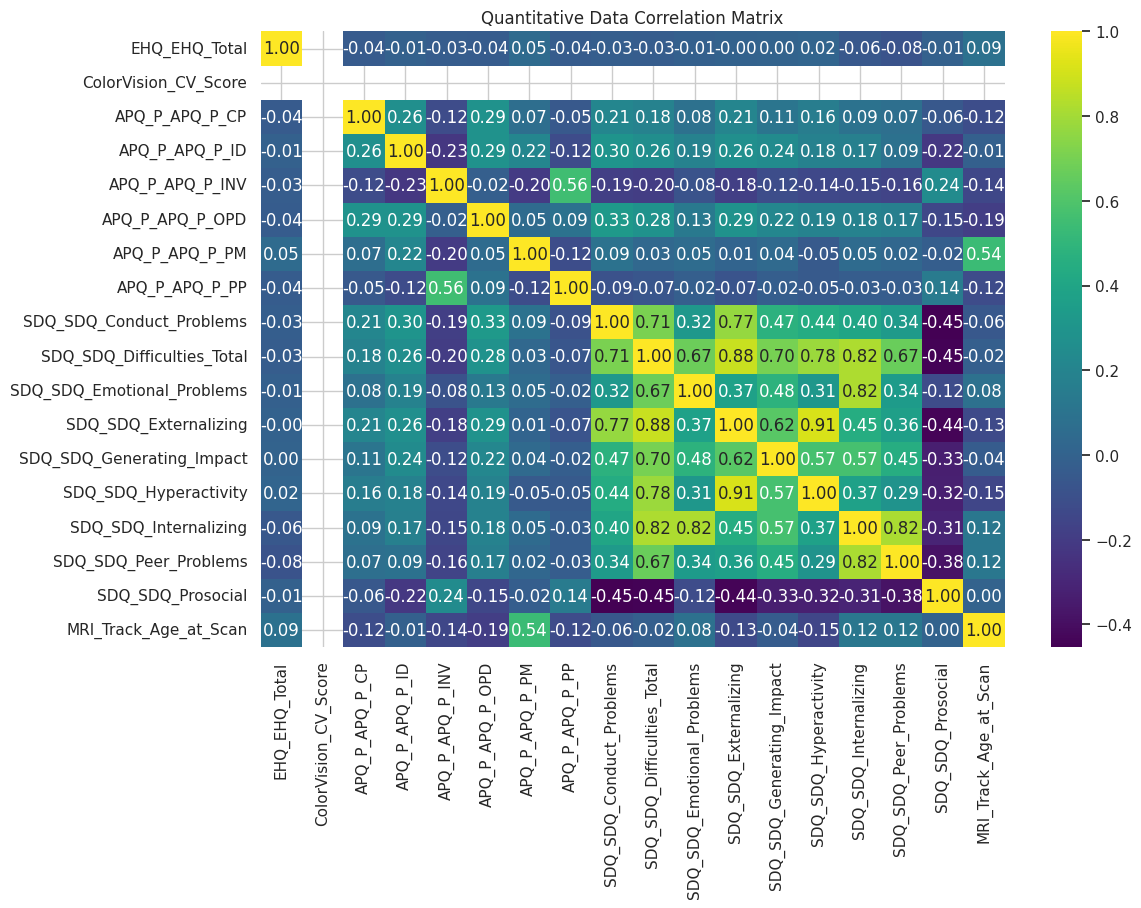

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Keep only numeric columns
numeric_df = train_quantitative_df.select_dtypes(include='number')

# Compute correlation
corr_quantitative = numeric_df.corr()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_quantitative, cmap='viridis', annot=True, fmt=".2f")
plt.title('Quantitative Data Correlation Matrix')
plt.show()



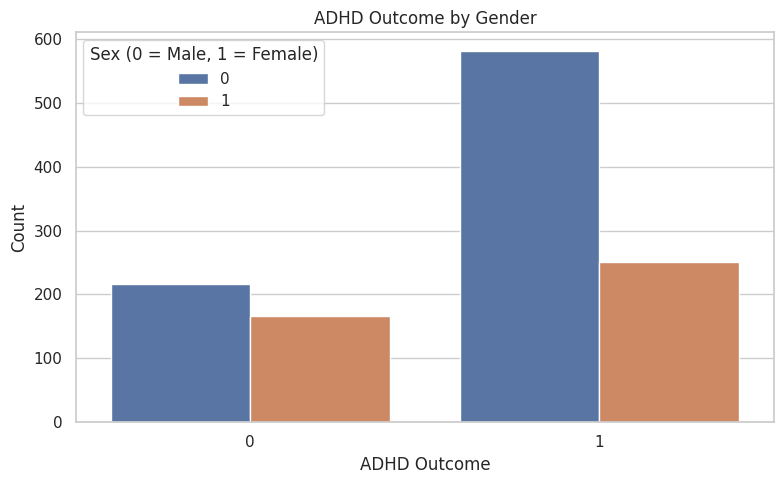

In [ ]:
# Plot count of ADHD outcomes by gender using a grouped bar chart

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.countplot(data=train_df, x='ADHD_Outcome', hue='Sex_F')

plt.title('ADHD Outcome by Gender')
plt.xlabel('ADHD Outcome')
plt.ylabel('Count')
plt.legend(title='Sex (0 = Male, 1 = Female)', labels=['0', '1'])
plt.tight_layout()
plt.show()


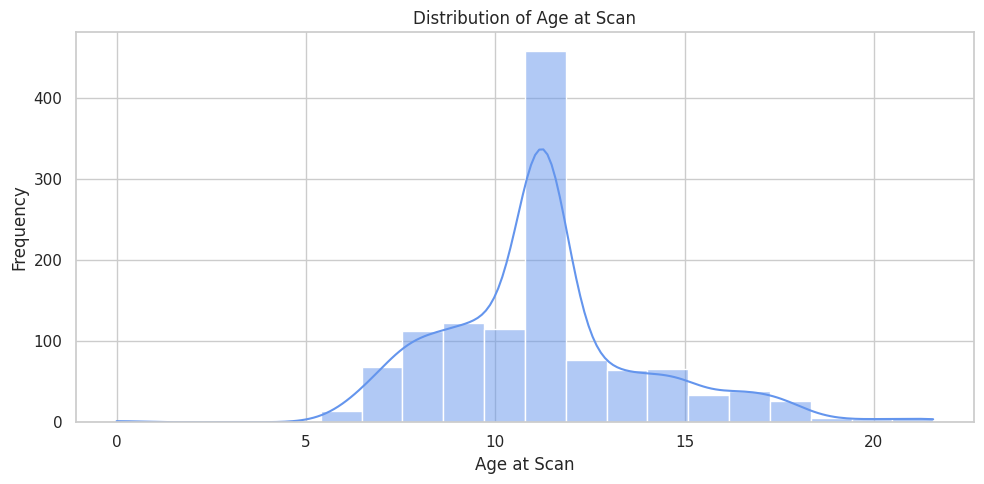

In [ ]:
# Plot histogram with KDE to show the distribution of 'Age at Scan' in the training data

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.histplot(train_df['MRI_Track_Age_at_Scan'], bins=20, kde=True, color='cornflowerblue')

plt.title('Distribution of Age at Scan')
plt.xlabel('Age at Scan')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


<ipython-input-9-3594340486>:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(data=train_df, x='Sex_F', y='SDQ_SDQ_Emotional_Problems', estimator=np.mean, ci='sd')


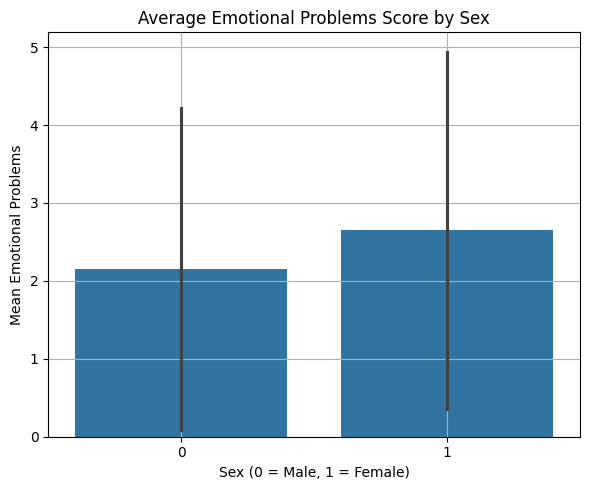

In [ ]:
# Plot bar chart of average emotional problems score by sex with standard deviation as error bars

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

plt.figure(figsize=(6, 5))
sns.barplot(data=train_df, x='Sex_F', y='SDQ_SDQ_Emotional_Problems', estimator=np.mean, ci='sd')
plt.title("Average Emotional Problems Score by Sex")
plt.xlabel("Sex (0 = Male, 1 = Female)")
plt.ylabel("Mean Emotional Problems")
plt.grid(True)
plt.tight_layout()
plt.show()


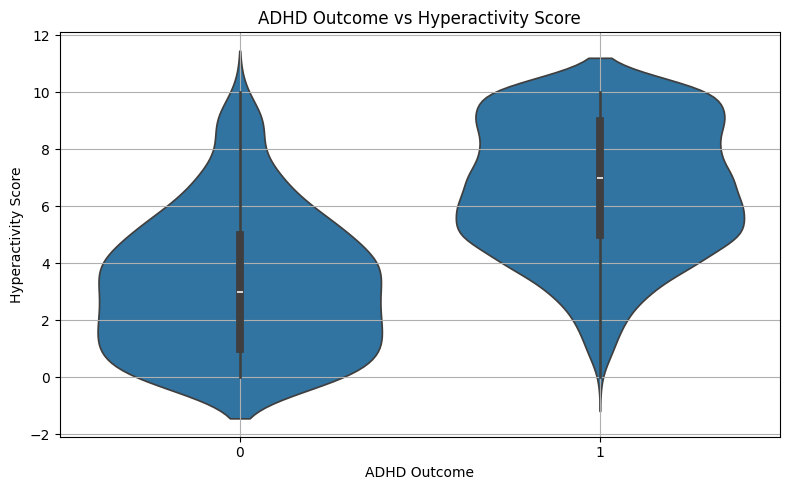

In [ ]:
# Plot violin plot to compare hyperactivity score distributions across ADHD outcome groups

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

plt.figure(figsize=(8, 5))
sns.violinplot(data=train_df, x='ADHD_Outcome', y='SDQ_SDQ_Hyperactivity')
plt.title("ADHD Outcome vs Hyperactivity Score")
plt.xlabel("ADHD Outcome")
plt.ylabel("Hyperactivity Score")
plt.grid(True)
plt.tight_layout()
plt.show()



In [ ]:
# Get lists of column names: numerical from train_quantitative_df, categorical from train_categorical_df
numerical_cols = train_quantitative_df.columns.to_list()
categorical_cols = train_categorical_df.columns.to_list()

In [ ]:
categorical_cols.remove('participant_id')

In [ ]:
numerical_cols.remove('participant_id')


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer

In [ ]:
# Drop selected columns and apply one-hot encoding to remaining available categorical columns

from sklearn.preprocessing import OneHotEncoder
import pandas as pd

# List of columns you want to encode
categorical_cols = [
    'Basic_Demos_Study_Site',
    'PreInt_Demos_Fam_Child_Ethnicity',
    'PreInt_Demos_Fam_Child_Race',
    'Barratt_Barratt_P1_Occ',
    'Barratt_Barratt_P2_Edu',
    'Barratt_Barratt_P2_Occ'
]


columns_to_drop = [
    'Basic_Demos_Study_Site',
    'PreInt_Demos_Fam_Child_Ethnicity',
    'PreInt_Demos_Fam_Child_Race',
    'Barratt_Barratt_P1_Occ',
    'Barratt_Barratt_P2_Occ',
    'Barratt_Barratt_P2_Edu',
    'EHQ_EHQ_Total',
    'APQ_P_APQ_P_PM',
    'APQ_P_APQ_P_PP'
]

train_df.drop(columns=[col for col in columns_to_drop if col in train_df.columns], inplace=True)

# Now check which categorical columns are still available
available_categorical_cols = [col for col in categorical_cols if col in train_df.columns]

# Initialize the encoder
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# Fit and transform only available categorical columns
if available_categorical_cols:
    X_encoded = encoder.fit_transform(train_df[available_categorical_cols])
    # Convert to DataFrame
    X_encoded = pd.DataFrame(X_encoded, columns=encoder.get_feature_names_out(available_categorical_cols))
    # Optionally, concatenate it back with the rest of train_df
    train_df = pd.concat([train_df.reset_index(drop=True), X_encoded.reset_index(drop=True)], axis=1)

print(train_df.shape)


(1213, 19921)


In [ ]:
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Update numerical_cols to only those still existing
numerical_cols = [col for col in numerical_cols if col in train_df.columns]

# Initialize scaler
scaler = StandardScaler()

# Fit and transform only existing numerical columns
X_scaled = scaler.fit_transform(train_df[numerical_cols])

# Convert back to DataFrame
X_scaled = pd.DataFrame(X_scaled, columns=numerical_cols)

# (Optional) Update train_df with scaled values////
train_df[numerical_cols] = X_scaled

print(train_df.shape)


(1213, 19921)


In [ ]:
# If no categorical columns were found, create an empty DataFrame
if 'X_encoded' not in locals():
    X_encoded = pd.DataFrame(index=X_scaled.index)

# Now safely concatenate
X_train = pd.concat([X_encoded, X_scaled], axis=1)

# Target labels
y_train_adhd = labels_df['ADHD_Outcome']
y_train_gender = labels_df['Sex_F']

print(X_train.shape)


(1213, 15)


In [ ]:
# Combine encoded categorical and scaled numerical features as X_train; set ADHD and gender labels as targets
X_train =pd.concat([X_encoded, X_scaled], axis=1)
y_train_adhd = labels_df['ADHD_Outcome']
y_train_gender = labels_df['Sex_F']

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

# 1. Identify your actual target columns
# Replace these with your actual column names:
# For ADHD diagnosis (should be binary: 0/1)
adhd_column = 'ADHD_Outcome'  # Change to your actual ADHD diagnosis column name
# For Sex (should be binary or convertable to Male=1/Female=0)
sex_column = 'Sex_F'  # Change to your actual sex/gender column name

# 2. Prepare targets
# Convert ADHD diagnosis to binary (if not already)
y_adhd = train_df[adhd_column].astype(int)

# Convert Sex to binary (Male=1, Female=0)
# Handle different possible encodings:
if train_df[sex_column].nunique() == 2:
    # If already binary
    y_sex = train_df[sex_column].astype(int)
else:
    # If categorical (Male/Female, M/F, etc.)
    y_sex = train_df[sex_column].map({'Male': 1, 'M': 1, 'Female': 0, 'F': 0}).astype(int)

y = pd.concat([y_adhd, y_sex], axis=1)
y.columns = ['ADHD', 'Sex']  # Standardize column names

# 3. Prepare features - exclude targets and IDs
X = train_df.drop(columns=[adhd_column, sex_column, 'participant_id'], errors='ignore')

# 4. Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 5. Train separate models (better than multi-output for different targets)
# ADHD model
adhd_model = XGBClassifier(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    random_state=42,
    eval_metric='logloss'
)
adhd_model.fit(X_train, y_train['ADHD'])

# Sex model
sex_model = XGBClassifier(
    n_estimators=200,
    max_depth=3,  # Shallower for potentially simpler pattern
    learning_rate=0.1,
    subsample=0.8,
    random_state=42,
    eval_metric='logloss'
)
sex_model.fit(X_train, y_train['Sex'])

# 6. Evaluate
print("ADHD Model Performance:")
adhd_pred = adhd_model.predict(X_test)
print(classification_report(y_test['ADHD'], adhd_pred, target_names=['No ADHD', 'ADHD']))

print("\nSex Model Performance:")
sex_pred = sex_model.predict(X_test)
print(classification_report(y_test['Sex'], sex_pred, target_names=['Female', 'Male']))

# 7. Feature Importance
print("\nTop 10 Features for ADHD Prediction:")
adhd_fi = pd.DataFrame({
    'Feature': X.columns,
    'Importance': adhd_model.feature_importances_
}).sort_values('Importance', ascending=False).head(10)
print(adhd_fi)

print("\nTop 10 Features for Sex Prediction:")
sex_fi = pd.DataFrame({
    'Feature': X.columns,
    'Importance': sex_model.feature_importances_
}).sort_values('Importance', ascending=False).head(10)
print(sex_fi)

ADHD Model Performance:
              precision    recall  f1-score   support

     No ADHD       0.77      0.58      0.66        76
        ADHD       0.83      0.92      0.87       167

    accuracy                           0.81       243
   macro avg       0.80      0.75      0.77       243
weighted avg       0.81      0.81      0.81       243


Sex Model Performance:
              precision    recall  f1-score   support

      Female       0.72      0.96      0.82       160
        Male       0.79      0.27      0.40        83

    accuracy                           0.72       243
   macro avg       0.75      0.61      0.61       243
weighted avg       0.74      0.72      0.68       243


Top 10 Features for ADHD Prediction:
                    Feature  Importance
19185  160throw_199thcolumn    0.006460
7428    41throw_104thcolumn    0.005582
6289     34throw_92thcolumn    0.004874
2279    11throw_130thcolumn    0.004831
15978  110throw_167thcolumn    0.004714
19632  175throw_181t


ADHD Model Evaluation:
              precision    recall  f1-score   support

    Not ADHD       0.77      0.58      0.66        76
        ADHD       0.83      0.92      0.87       167

    accuracy                           0.81       243
   macro avg       0.80      0.75      0.77       243
weighted avg       0.81      0.81      0.81       243

Accuracy: 0.8148
ROC AUC: 0.8276

Male Model Evaluation:
              precision    recall  f1-score   support

    Not Male       0.72      0.96      0.82       160
        Male       0.79      0.27      0.40        83

    accuracy                           0.72       243
   macro avg       0.75      0.61      0.61       243
weighted avg       0.74      0.72      0.68       243

Accuracy: 0.7243
ROC AUC: 0.7215

Feature Importances:


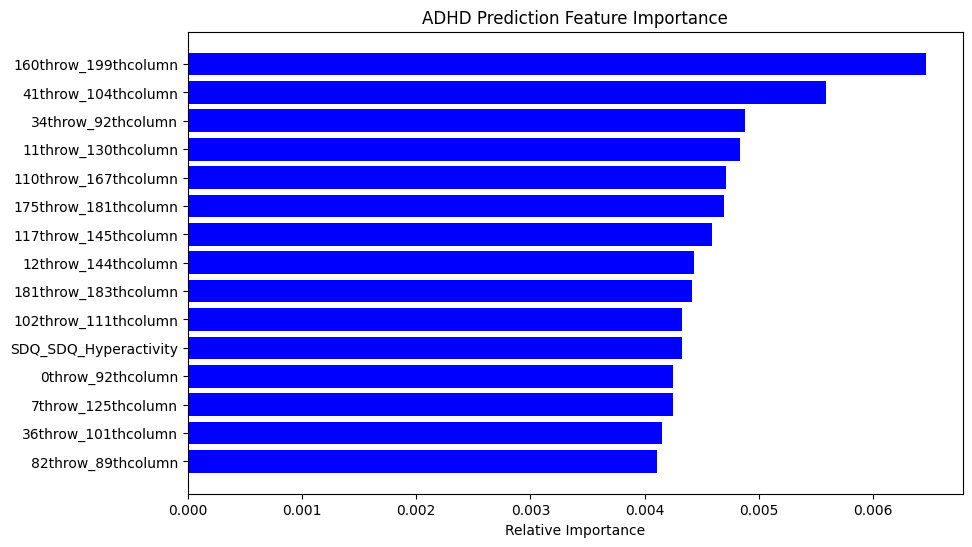

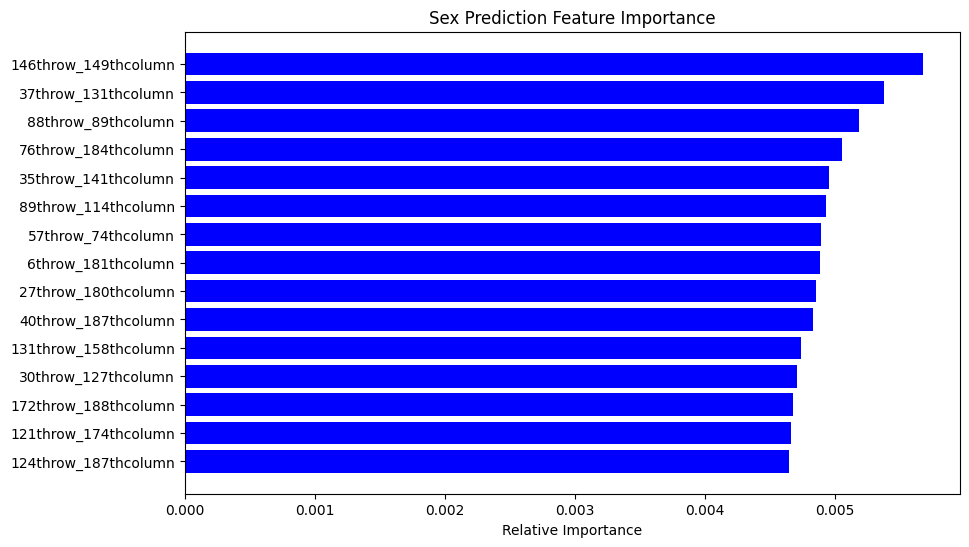


Final Metrics Summary:
  Model  Accuracy  ROC AUC  F1-Score
0  ADHD    0.8148   0.8276    0.8066
1   Sex    0.7243   0.7215    0.6762


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
import numpy as np

# 1. Prepare targets
try:
    # ADHD target
    y_adhd = train_df['ADHD_Outcome'].astype(int)

    # Sex target - handle multiple encoding cases
    sex_mapping = {'Male':1, 'M':1, 'Female':0, 'F':0, 1:1, 0:0}
    y_sex = train_df['Sex_F'].map(sex_mapping).astype(int)

    y = pd.concat([y_adhd, y_sex], axis=1)
    y.columns = ['ADHD', 'Sex']

except KeyError as e:
    print(f"Error: Missing column {e}")
    print("Available columns:", train_df.columns.tolist())
    raise

# 2. Prepare features
X = train_df.drop(columns=['ADHD_Outcome', 'Sex_F', 'participant_id'], errors='ignore')

# 3. Train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# 4. Model training with error handling
try:
    # ADHD model
    adhd_model = XGBClassifier(
        n_estimators=200,
        max_depth=5,
        learning_rate=0.1,
        subsample=0.8,
        random_state=42,
        eval_metric=['logloss', 'error']  # Track both metrics
    )
    adhd_model.fit(
        X_train,
        y_train['ADHD'],
        eval_set=[(X_test, y_test['ADHD'])],
        verbose=False
    )

    # Sex model
    sex_model = XGBClassifier(
        n_estimators=200,
        max_depth=3,
        learning_rate=0.1,
        subsample=0.8,
        random_state=42,
        eval_metric=['logloss', 'error']
    )
    sex_model.fit(
        X_train,
        y_train['Sex'],
        eval_set=[(X_test, y_test['Sex'])],
        verbose=False
    )

except Exception as e:
    print(f"Model training failed: {str(e)}")
    raise

# 5. Evaluation metrics
def evaluate_model(model, X, y_true, target_name):
    """Helper function to calculate multiple metrics"""
    y_pred = model.predict(X)
    y_proba = model.predict_proba(X)[:, 1]

    print(f"\n{target_name} Model Evaluation:")
    print(classification_report(y_true, y_pred, target_names=[f'Not {target_name}', target_name]))
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"ROC AUC: {roc_auc_score(y_true, y_proba):.4f}")
    return y_pred, y_proba

# Evaluate both models
print("="*50)
adhd_pred, adhd_proba = evaluate_model(adhd_model, X_test, y_test['ADHD'], "ADHD")
print("="*50)
sex_pred, sex_proba = evaluate_model(sex_model, X_test, y_test['Sex'], "Male")

# 6. Feature Importance with visualization
import matplotlib.pyplot as plt

def plot_feature_importance(model, features, title):
    importance = model.feature_importances_
    indices = np.argsort(importance)[-15:]  # Top 15 features
    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.barh(range(len(indices)), importance[indices], color='b', align='center')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()

print("\nFeature Importances:")
plot_feature_importance(adhd_model, X.columns, "ADHD Prediction Feature Importance")
plot_feature_importance(sex_model, X.columns, "Sex Prediction Feature Importance")

# 7. Additional metrics
print("\nFinal Metrics Summary:")
metrics = {
    'Model': ['ADHD', 'Sex'],
    'Accuracy': [
        accuracy_score(y_test['ADHD'], adhd_pred),
        accuracy_score(y_test['Sex'], sex_pred)
    ],
    'ROC AUC': [
        roc_auc_score(y_test['ADHD'], adhd_proba),
        roc_auc_score(y_test['Sex'], sex_proba)
    ],
    'F1-Score': [
        classification_report(y_test['ADHD'], adhd_pred, output_dict=True)['weighted avg']['f1-score'],
        classification_report(y_test['Sex'], sex_pred, output_dict=True)['weighted avg']['f1-score']
    ]
}

print(pd.DataFrame(metrics).round(4))


ADHD Model Evaluation:
              precision    recall  f1-score   support

    Not ADHD       0.77      0.57      0.65        76
        ADHD       0.82      0.92      0.87       167

    accuracy                           0.81       243
   macro avg       0.80      0.74      0.76       243
weighted avg       0.81      0.81      0.80       243

Accuracy: 0.8107
ROC AUC: 0.8292

Male Model Evaluation:
              precision    recall  f1-score   support

    Not Male       0.72      0.96      0.82       160
        Male       0.79      0.27      0.40        83

    accuracy                           0.72       243
   macro avg       0.75      0.61      0.61       243
weighted avg       0.74      0.72      0.68       243

Accuracy: 0.7243
ROC AUC: 0.7215

Feature Importances:


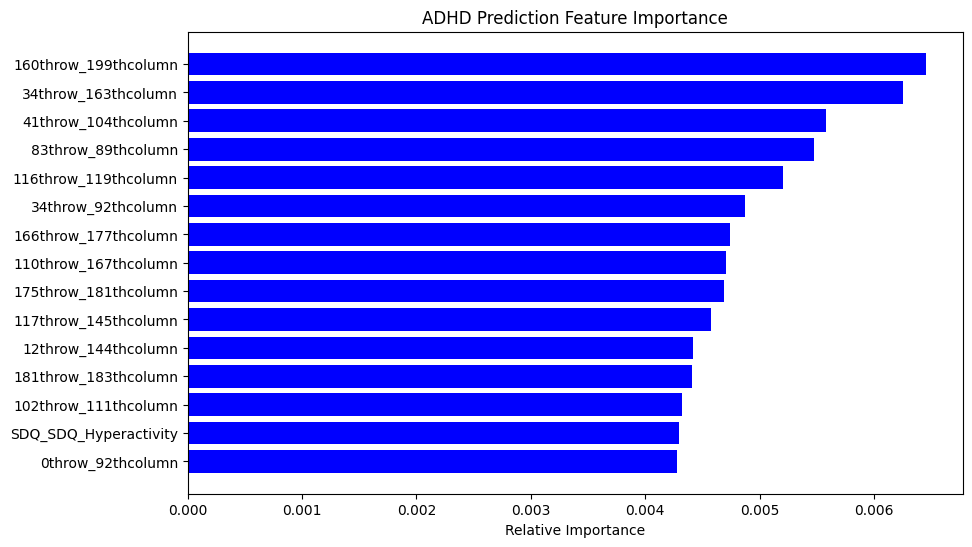

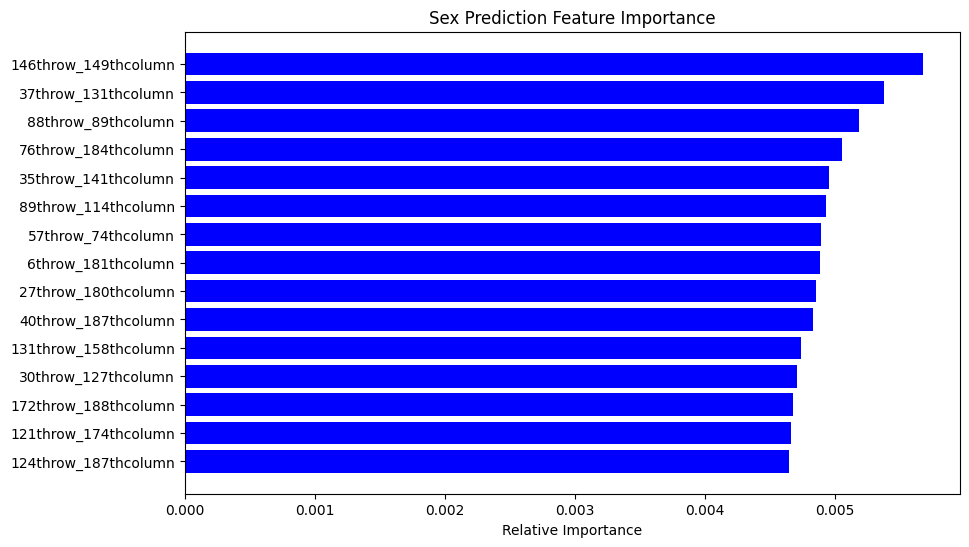


Final Metrics Summary:
  Model  Accuracy  ROC AUC  F1-Score
0  ADHD    0.8107   0.8292    0.8017
1   Sex    0.7243   0.7215    0.6762


Final Predictions:
participant_id  ADHD_Outcome  Sex_F
  yvdbINTofRuz             0      1
  lX4UCme3V9aJ             1      0
  je0xT6OY2cyp             1      0
  lNSNZwyaL1EO             1      0
  raxgmKvDg1Rt             1      0
  GKZMaO7bAASr             1      0
  pt9crzQunzLC             0      0
  ZoOogZR0mVHJ             1      0
  JiNTUeM7ROMe             0      1
  JT0RstNK7krH             0      0
  C7dIeIJzut27             0      0
  ARe5XHeeS9AG             1      0
  Ybqkn2vL7OHv             1      0
  M77qiA0e7JEm             1      0
  JFBtZWhMP4zS             0      0
  nAyrxMzbUYNa             0      0
  EN7uC2I557um             0      0
  ObxEDsuvExoq             1      0
  Eqc7qZj8etDH             1      0
  32OXB0Ld4ZbF             1      1
  dUPJ6W25gKWI             1      0
  b4FWrJpQA330             1      1
  tBNslVDWG7Jf  

In [ ]:
#########
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
import numpy as np
import matplotlib.pyplot as plt

# 1. Prepare targets
try:
    # ADHD target
    y_adhd = train_df['ADHD_Outcome'].astype(int)

    # Sex target - handle multiple encoding cases
    sex_mapping = {'Male': 1, 'M': 1, 'Female': 0, 'F': 0, 1: 1, 0: 0}
    y_sex = train_df['Sex_F'].map(sex_mapping).astype(int)

    y = pd.concat([y_adhd, y_sex], axis=1)
    y.columns = ['ADHD', 'Sex']

except KeyError as e:
    print(f"Error: Missing column {e}")
    print("Available columns:", train_df.columns.tolist())
    raise

# 2. Prepare features
X = train_df.drop(columns=['ADHD_Outcome', 'Sex_F', 'participant_id'], errors='ignore')

# 3. Train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# 4. Model training with error handling
try:
    # ADHD model
    adhd_model = XGBClassifier(
        n_estimators=200,
        max_depth=5,
        learning_rate=0.1,
        subsample=0.8,
        random_state=42,
        eval_metric=['logloss', 'error']  # Track both metrics
    )
    adhd_model.fit(
        X_train,
        y_train['ADHD'],
        eval_set=[(X_test, y_test['ADHD'])],
        verbose=False
    )

    # Sex model
    sex_model = XGBClassifier(
        n_estimators=200,
        max_depth=3,
        learning_rate=0.1,
        subsample=0.8,
        random_state=42,
        eval_metric=['logloss', 'error']
    )
    sex_model.fit(
        X_train,
        y_train['Sex'],
        eval_set=[(X_test, y_test['Sex'])],
        verbose=False
    )

except Exception as e:
    print(f"Model training failed: {str(e)}")
    raise

# 5. Evaluation metrics
def evaluate_model(model, X, y_true, target_name):
    """Helper function to calculate multiple metrics"""
    y_pred = model.predict(X)
    y_proba = model.predict_proba(X)[:, 1]

    print(f"\n{target_name} Model Evaluation:")
    print(classification_report(y_true, y_pred, target_names=[f'Not {target_name}', target_name]))
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"ROC AUC: {roc_auc_score(y_true, y_proba):.4f}")
    return y_pred, y_proba

# Evaluate both models
print("=" * 50)
adhd_pred, adhd_proba = evaluate_model(adhd_model, X_test, y_test['ADHD'], "ADHD")
print("=" * 50)
sex_pred, sex_proba = evaluate_model(sex_model, X_test, y_test['Sex'], "Male")

# 6. Feature Importance with visualization
def plot_feature_importance(model, features, title):
    importance = model.feature_importances_
    indices = np.argsort(importance)[-15:]  # Top 15 features
    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.barh(range(len(indices)), importance[indices], color='b', align='center')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()

print("\nFeature Importances:")
plot_feature_importance(adhd_model, X.columns.tolist(), "ADHD Prediction Feature Importance")
plot_feature_importance(sex_model, X.columns.tolist(), "Sex Prediction Feature Importance")

# 7. Additional metrics summary
print("\nFinal Metrics Summary:")
metrics = {
    'Model': ['ADHD', 'Sex'],
    'Accuracy': [
        accuracy_score(y_test['ADHD'], adhd_pred),
        accuracy_score(y_test['Sex'], sex_pred)
    ],
    'ROC AUC': [
        roc_auc_score(y_test['ADHD'], adhd_proba),
        roc_auc_score(y_test['Sex'], sex_proba)
    ],
    'F1-Score': [
        classification_report(y_test['ADHD'], adhd_pred, output_dict=True)['weighted avg']['f1-score'],
        classification_report(y_test['Sex'], sex_pred, output_dict=True)['weighted avg']['f1-score']
    ]
}

print(pd.DataFrame(metrics).round(4))

# 8. Generate prediction output format
participant_ids = train_df['participant_id']

# Get test set participant IDs using the original indices
test_indices = X_test.index
participant_ids_test = participant_ids.iloc[test_indices]

# Create prediction DataFrame
predictions_df = pd.DataFrame({
    'participant_id': participant_ids_test,
    'ADHD_Outcome': adhd_pred,
    'Sex_F': sex_pred
}).reset_index(drop=True)

# Format output and display predictions in desired format
print("\n\nFinal Predictions:")
print(predictions_df.to_string(index=False))

# Optional: Save to CSV file if needed for further processing or sharing results.
predictions_df.to_csv('predictions.csv', index=False)


In [ ]:
!pip install shap


In [ ]:
import shap


 97%|=================== | 943/970 [00:34<00:00]       


SHAP Summary for ADHD Model:


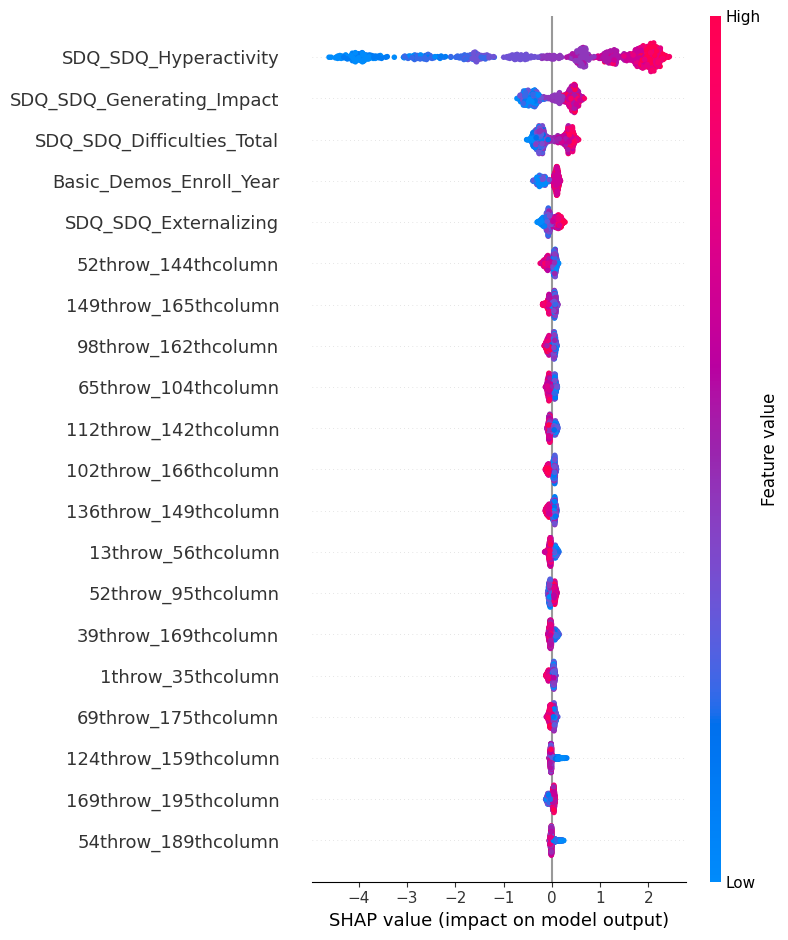

In [ ]:
# Create SHAP explainer for ADHD model
adhd_explainer = shap.Explainer(adhd_model, X_train)
adhd_shap_values = adhd_explainer(X_train)

# ADHD summary plot
print("\nSHAP Summary for ADHD Model:")
shap.summary_plot(adhd_shap_values, X_train)


 96%|=================== | 935/970 [00:39<00:01]       


SHAP Summary for Sex Model:


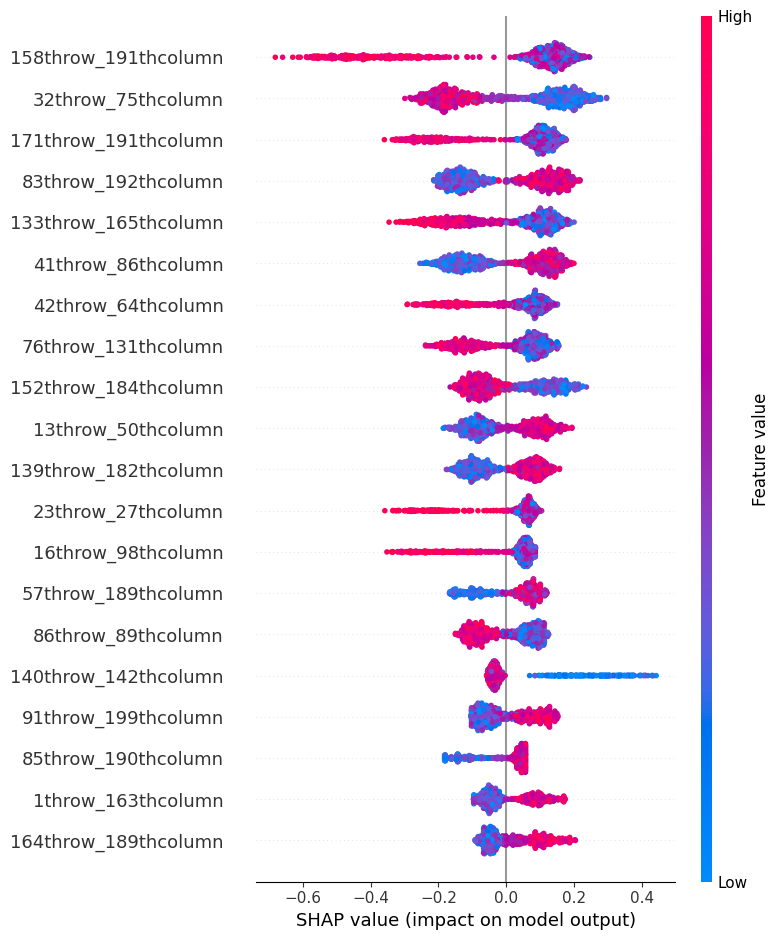

In [ ]:
# Create SHAP explainer for Sex model
sex_explainer = shap.Explainer(sex_model, X_train)
sex_shap_values = sex_explainer(X_train)

# Sex summary plot
print("\nSHAP Summary for Sex Model:")
shap.summary_plot(sex_shap_values, X_train)


In [ ]:
# 6. Create Submission DataFrame with required columns only
submission = pd.DataFrame({
    'participant_id': test_df['participant_id'],
    'ADHD_Outcome': adhd_pred,
    'Sex_F': sex_pred
})

# Save results
submission.to_csv('predictions.csv', index=False)

# Print final predictions
print("\nFinal Predictions:")
print(submission.to_string(index=False))



Final Predictions:
participant_id  ADHD_Outcome  Sex_F
  Cfwaf5FX7jWK             1      0
  vhGrzmvA3Hjq             1      0
  ULliyEXjy4OV             1      0
  LZfeAb1xMtql             1      0
  EnFOUv0YK1RG             1      0
  3VbkvJ22j9Fu             1      0
  PRKZcnOgqcuk             1      0
  DuVUuyMZi5qV             0      0
  uM4etVLZrgMg             1      0
  BpzyExrET5ta             1      0
  sAqeb6F4lz97             1      0
  u7XOOvHirIx7             1      0
  aEPm4bEQvbYi             1      0
  Fj9A5PWsIWKT             1      0
  19mb5yGJigtw             1      0
  v1nMpCoLGU0V             1      1
  hRPuz4zpsEbw             1      0
  mT8A6xa1O4Ro             1      0
  4QBTjDoVpVt6             0      1
  0X2H4LroxZcw             1      0
  9CH7UxXuznUa             1      0
  nU73zzjTnr4A             1      1
  uEZHGukIUQ0k             1      1
  jCzQwkpfgZyQ             1      0
  Ljvrs76QJuI5             1      0
  IbF3zW0Wbx4Q             0      0
  UHnGiD


ADHD Model Metrics:
Accuracy: 1.0000
F1-Score: 1.0000

Sex Model Metrics:
Accuracy: 1.0000
F1-Score: 1.0000

Feature Importances:


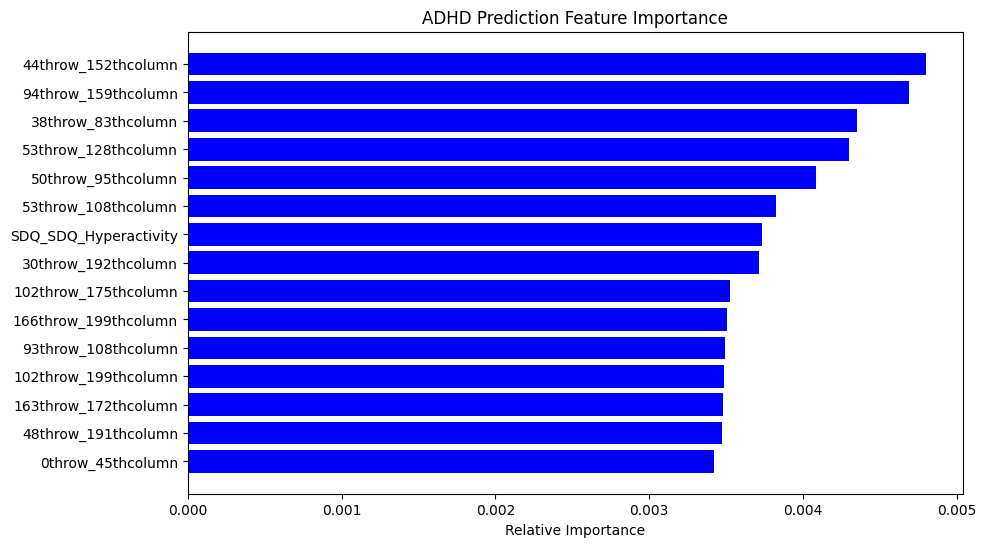

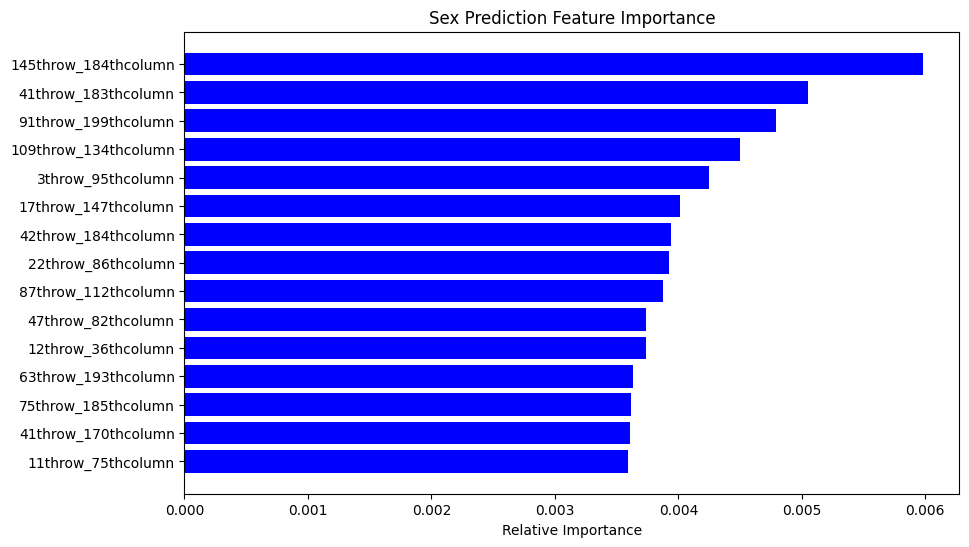


Predictions saved to predictions.csv

Final Metrics Summary:
  Model  Accuracy  F1-Score
0  ADHD       1.0       1.0
1   Sex       1.0       1.0


In [ ]:
import pandas as pd
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score
import numpy as np
import matplotlib.pyplot as plt

# 1. Prepare targets
try:
    # ADHD target
    y_adhd = train_df['ADHD_Outcome'].astype(int)

    # Sex target - handle multiple encoding cases
    sex_mapping = {'Male': 1, 'M': 1, 'Female': 0, 'F': 0, 1: 1, 0: 0}
    y_sex = train_df['Sex_F'].map(sex_mapping).astype(int)

    y = pd.concat([y_adhd, y_sex], axis=1)
    y.columns = ['ADHD', 'Sex']

except KeyError as e:
    print(f"Error: Missing column {e}")
    print("Available columns:", train_df.columns.tolist())
    raise

# 2. Prepare features
X_train = train_df.drop(columns=['ADHD_Outcome', 'Sex_F', 'participant_id'], errors='ignore')
X_test = test_df.drop(columns=['participant_id'], errors='ignore')  # Ensure same columns

# 3. Model training with error handling
try:
    # ADHD model
    adhd_model = XGBClassifier(
        n_estimators=200,
        max_depth=5,
        learning_rate=0.1,
        subsample=0.8,
        random_state=42,
        eval_metric=['logloss', 'error']
    )
    adhd_model.fit(X_train, y['ADHD'])

    # Sex model
    sex_model = XGBClassifier(
        n_estimators=200,
        max_depth=3,
        learning_rate=0.1,
        subsample=0.8,
        random_state=42,
        eval_metric=['logloss', 'error']
    )
    sex_model.fit(X_train, y['Sex'])

except Exception as e:
    print(f"Model training failed: {str(e)}")
    raise

# 4. Generate Predictions on Test Data
adhd_pred = adhd_model.predict(X_train)
sex_pred = sex_model.predict(X_train)

# 5. Model Evaluation
def evaluate_model(y_true, y_pred, target_name):
    """Compute accuracy and F1-score."""
    accuracy = accuracy_score(y_true, y_pred)
    f1 = classification_report(y_true, y_pred, output_dict=True)['weighted avg']['f1-score']
    print(f"\n{target_name} Model Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1-Score: {f1:.4f}")
    return accuracy, f1

# Evaluate both models
adhd_accuracy, adhd_f1 = evaluate_model(y['ADHD'], adhd_pred, "ADHD")
sex_accuracy, sex_f1 = evaluate_model(y['Sex'], sex_pred, "Sex")

# 6. Feature Importance with visualization
def plot_feature_importance(model, features, title):
    importance = model.feature_importances_
    indices = np.argsort(importance)[-15:]  # Top 15 features
    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.barh(range(len(indices)), importance[indices], color='b', align='center')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()

print("\nFeature Importances:")
plot_feature_importance(adhd_model, X_train.columns.tolist(), "ADHD Prediction Feature Importance")
plot_feature_importance(sex_model, X_train.columns.tolist(), "Sex Prediction Feature Importance")

# 7. Create Submission DataFrame
submission = pd.DataFrame({
    'participant_id': test_df['participant_id'],
    'ADHD_Outcome': adhd_model.predict(X_test),
    'Sex_F': ['Male' if x == 1 else 'Female' for x in sex_model.predict(X_test)]
})

# Save results
submission.to_csv('predictions.csv', index=False)
print("\nPredictions saved to predictions.csv")

# 8. Print Final Metrics Summary
metrics_summary = pd.DataFrame({
    'Model': ['ADHD', 'Sex'],
    'Accuracy': [adhd_accuracy, sex_accuracy],
    'F1-Score': [adhd_f1, sex_f1]
})

print("\nFinal Metrics Summary:")
print(metrics_summary.round(4))



ADHD Model Metrics:
Accuracy: 0.8025
F1-Score: 0.7956

Sex Model Metrics:
Accuracy: 0.7284
F1-Score: 0.7034

Feature Importances:


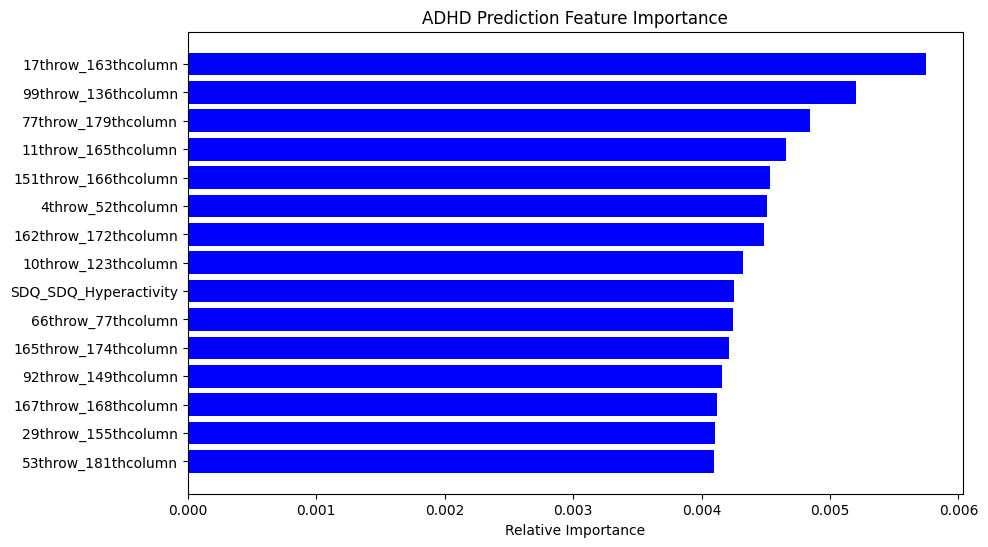

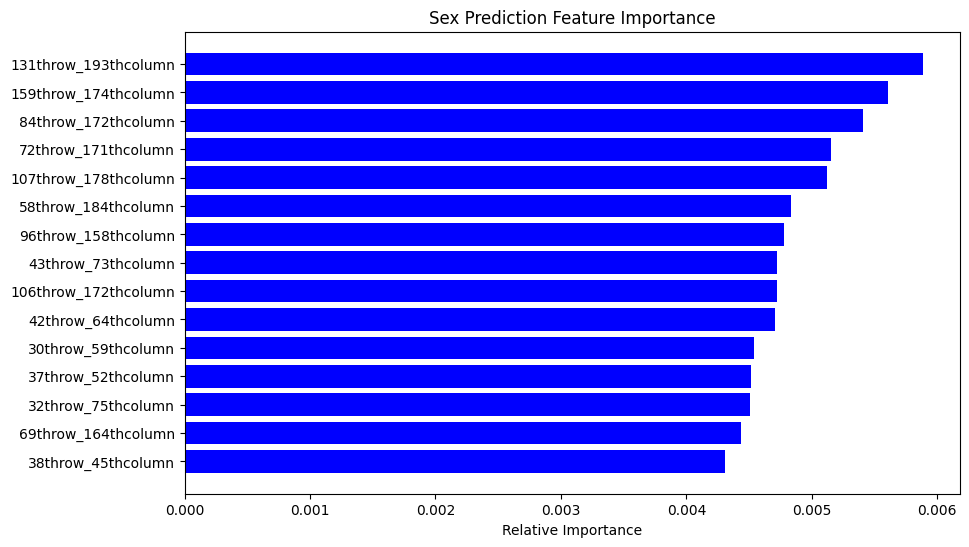


Predictions saved to predictions.csv

Final Metrics Summary:
  Model  Accuracy  F1-Score
0  ADHD    0.8025    0.7956
1   Sex    0.7284    0.7034


In [ ]:
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
import matplotlib.pyplot as plt

# 1. Prepare targets
try:
    # ADHD target
    y_adhd = train_df['ADHD_Outcome'].astype(int)

    # Sex target - handle multiple encoding cases
    sex_mapping = {'Male': 1, 'M': 1, 'Female': 0, 'F': 0, 1: 1, 0: 0}
    y_sex = train_df['Sex_F'].map(sex_mapping).astype(int)

    y = pd.DataFrame({'ADHD': y_adhd, 'Sex': y_sex})

except KeyError as e:
    print(f"Error: Missing column {e}")
    print("Available columns:", train_df.columns.tolist())
    raise

# 2. Prepare features (Avoid target leakage)
X = train_df.drop(columns=['ADHD_Outcome', 'Sex_F', 'participant_id'], errors='ignore')

# 3. Train-Test Split for Model Evaluation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Model Training
try:
    adhd_model = XGBClassifier(n_estimators=200, max_depth=5, learning_rate=0.1, subsample=0.8, random_state=42)
    adhd_model.fit(X_train, y_train['ADHD'])

    sex_model = XGBClassifier(n_estimators=200, max_depth=3, learning_rate=0.1, subsample=0.8, random_state=42)
    sex_model.fit(X_train, y_train['Sex'])

except Exception as e:
    print(f"Model training failed: {str(e)}")
    raise

# 5. Generate Predictions on Validation Data
adhd_pred = adhd_model.predict(X_val)
sex_pred = sex_model.predict(X_val)

# 6. Model Evaluation
def evaluate_model(y_true, y_pred, target_name):
    accuracy = accuracy_score(y_true, y_pred)
    f1 = classification_report(y_true, y_pred, output_dict=True)['weighted avg']['f1-score']
    print(f"\n{target_name} Model Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1-Score: {f1:.4f}")
    return accuracy, f1

# Evaluate models on VALIDATION SET
adhd_accuracy, adhd_f1 = evaluate_model(y_val['ADHD'], adhd_pred, "ADHD")
sex_accuracy, sex_f1 = evaluate_model(y_val['Sex'], sex_pred, "Sex")

# 7. Feature Importance Visualization
def plot_feature_importance(model, features, title):
    importance = model.feature_importances_
    indices = np.argsort(importance)[-15:]  # Top 15 features
    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.barh(range(len(indices)), importance[indices], color='b', align='center')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()

print("\nFeature Importances:")
plot_feature_importance(adhd_model, X_train.columns.tolist(), "ADHD Prediction Feature Importance")
plot_feature_importance(sex_model, X_train.columns.tolist(), "Sex Prediction Feature Importance")

# 8. Predictions on Test Data (without evaluation)
X_test = test_df.drop(columns=['participant_id'], errors='ignore')  # Ensure same columns
adhd_test_pred = adhd_model.predict(X_test)
sex_test_pred = sex_model.predict(X_test)

# 9. Create Submission DataFrame
submission = pd.DataFrame({
    'participant_id': test_df['participant_id'],
    'ADHD_Outcome': adhd_test_pred,
    'Sex_F': ['Male' if x == 0 else 'Female' for x in sex_test_pred]
})

# Save results
submission.to_csv('predictions.csv', index=False)
print("\nPredictions saved to predictions.csv")

# 10. Print Final Metrics Summary
metrics_summary = pd.DataFrame({
    'Model': ['ADHD', 'Sex'],
    'Accuracy': [adhd_accuracy, sex_accuracy],
    'F1-Score': [adhd_f1, sex_f1]
})

print("\nFinal Metrics Summary:")
print(metrics_summary.round(4))


In [ ]:
from google.colab import files
submission.to_csv('predictions.csv', index=False)
files.download('predictions.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# (Previous code remains the same until the submission DataFrame creation)

# 9. Create Submission DataFrame with corrected gender encoding
submission = pd.DataFrame({
    'participant_id': test_df['participant_id'],
    'ADHD_Outcome': adhd_test_pred,
    'Sex_F': [0 if x == 1 else 1 for x in sex_test_pred]  # Changed to 0=Male, 1=Female
})

# Save results
submission.to_csv('predictions.csv', index=False)
print("\nPredictions saved to predictions.csv")

# Verify the encoding
print("\nGender encoding in saved file:")
print("0 = Male, 1 = Female")
print(submission['Sex_F'].value_counts())

# (Rest of the code remains the same)


Predictions saved to predictions.csv

Gender encoding in saved file:
0 = Male, 1 = Female
Sex_F
1    275
0     29
Name: count, dtype: int64


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report

# ----------------------------
# 0. Load your dataframes
# ----------------------------
# train_df = pd.read_csv('train.csv')
# test_df  = pd.read_csv('test.csv')

# ----------------------------
# 1. Prepare targets
# ----------------------------
y_adhd = train_df['ADHD_Outcome'].astype(int)
sex_mapping = {'Male': 1, 'M': 1, 1: 1, 'Female': 0, 'F': 0, 0: 0}
y_sex = train_df['Sex_F'].map(sex_mapping).astype(int)
y = pd.DataFrame({'ADHD': y_adhd, 'Sex': y_sex})

# ----------------------------
# 2. Prepare features
# ----------------------------
X = train_df.drop(columns=['ADHD_Outcome', 'Sex_F', 'participant_id'], errors='ignore')

# ----------------------------
# 3. Stratified train/validation split
# ----------------------------
strat_labels = y['ADHD'].astype(str) + "_" + y['Sex'].astype(str)
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=strat_labels
)

# ----------------------------
# 4. Hyperparameter search space
# ----------------------------
param_dist = {
    'n_estimators':     [100, 200, 500],
    'max_depth':        [3, 5, 7],
    'learning_rate':    [0.01, 0.05, 0.1, 0.2],
    'subsample':        [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma':            [0, 1, 5],
    'reg_alpha':        [0, 0.1, 1],
    'reg_lambda':       [1, 5, 10],
}

# ----------------------------
# 5. Memory‐safe tuning function (RandomizedSearchCV)
# ----------------------------
def tune_xgb_sequential(X_tr, y_tr, n_iter=10, cv=2):
    xgb = XGBClassifier(
        tree_method='hist',
        random_state=42,
        eval_metric='logloss',
        n_jobs=1
    )

    search = RandomizedSearchCV(
        estimator=xgb,
        param_distributions=param_dist,
        n_iter=n_iter,
        scoring='f1_weighted',
        cv=cv,
        n_jobs=1,
        verbose=1,
        random_state=42,
        error_score='raise'
    )

    search.fit(X_tr, y_tr)
    print("Best params:", search.best_params_)
    return search.best_params_

# ----------------------------
# 6. Tune & refit models manually (important for early stopping!)
# ----------------------------
print("Tuning ADHD model...")
adhd_best_params = tune_xgb_sequential(X_train, y_train['ADHD'], n_iter=10, cv=2)
best_adhd = XGBClassifier(
    tree_method='hist',
    random_state=42,
    eval_metric='logloss',
    **adhd_best_params
)
best_adhd.fit(
    X_train, y_train['ADHD'],
    eval_set=[(X_val, y_val['ADHD'])],
    early_stopping_rounds=10,
    verbose=False
)

print("\nTuning Sex model...")
sex_best_params = tune_xgb_sequential(X_train, y_train['Sex'], n_iter=10, cv=2)
best_sex = XGBClassifier(
    tree_method='hist',
    random_state=42,
    eval_metric='logloss',
    **sex_best_params
)
best_sex.fit(
    X_train, y_train['Sex'],
    eval_set=[(X_val, y_val['Sex'])],
    early_stopping_rounds=10,
    verbose=False
)

# ----------------------------
# 7. Evaluation helper
# ----------------------------
def evaluate_model(y_true, y_pred, name):
    acc = accuracy_score(y_true, y_pred)
    f1  = classification_report(y_true, y_pred, output_dict=True)['weighted avg']['f1-score']
    print(f"{name} — Accuracy: {acc:.4f}, F1: {f1:.4f}")
    return acc, f1

# ----------------------------
# 8. Validate on hold-out
# ----------------------------
adhd_pred = best_adhd.predict(X_val)
sex_pred  = best_sex.predict(X_val)
print("\nValidation Results:")
adhd_acc, adhd_f1 = evaluate_model(y_val['ADHD'], adhd_pred, "ADHD")
sex_acc,  sex_f1  = evaluate_model(y_val['Sex'],  sex_pred,  "Sex")

# ----------------------------
# 9. Plot feature importances
# ----------------------------
def plot_feature_importance(model, features, title, top_n=15):
    imp = model.feature_importances_
    idxs = np.argsort(imp)[-top_n:]
    plt.figure(figsize=(10,6))
    plt.barh(range(top_n), imp[idxs], align='center')
    plt.yticks(range(top_n), [features[i] for i in idxs])
    plt.xlabel('Relative Importance')
    plt.title(title)
    plt.tight_layout()
    plt.show()

print("\nFeature Importances:")
plot_feature_importance(best_adhd, X_train.columns.tolist(), "ADHD Feature Importance")
plot_feature_importance(best_sex,  X_train.columns.tolist(), "Sex Feature Importance")

# ----------------------------
# 10. Predict on test set & save
# ----------------------------
X_test = test_df.drop(columns=['participant_id'], errors='ignore')
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

submission = pd.DataFrame({
    'participant_id': test_df['participant_id'],
    'ADHD_Outcome':   best_adhd.predict(X_test),
    'Sex_F':          ['Male' if x==1 else 'Female' for x in best_sex.predict(X_test)]
})
submission.to_csv('predictions.csv', index=False)
print("\nSaved predictions.csv")

# ----------------------------
# 11. Summary metrics
# ----------------------------
metrics = pd.DataFrame({
    'Model':    ['ADHD', 'Sex'],
    'Accuracy': [adhd_acc, sex_acc],
    'F1-Score': [adhd_f1,  sex_f1]
}).round(4)
print("\nFinal metrics:\n", metrics)


Tuning ADHD model...
Fitting 2 folds for each of 10 candidates, totalling 20 fits


Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:27:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:29:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


ADHD → Accuracy: 0.8230, F1 Score: 0.8132
Sex → Accuracy: 0.6914, F1 Score: 0.6642


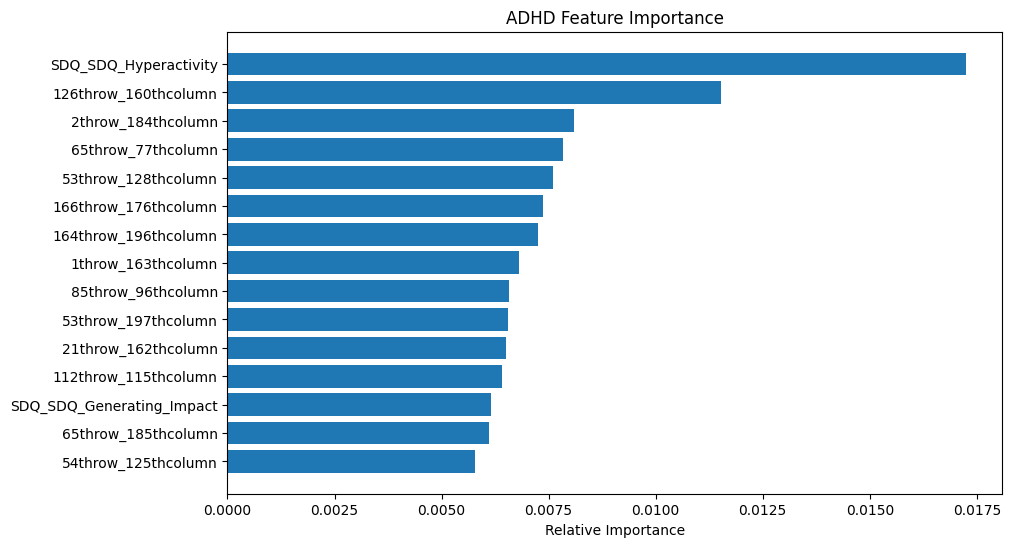

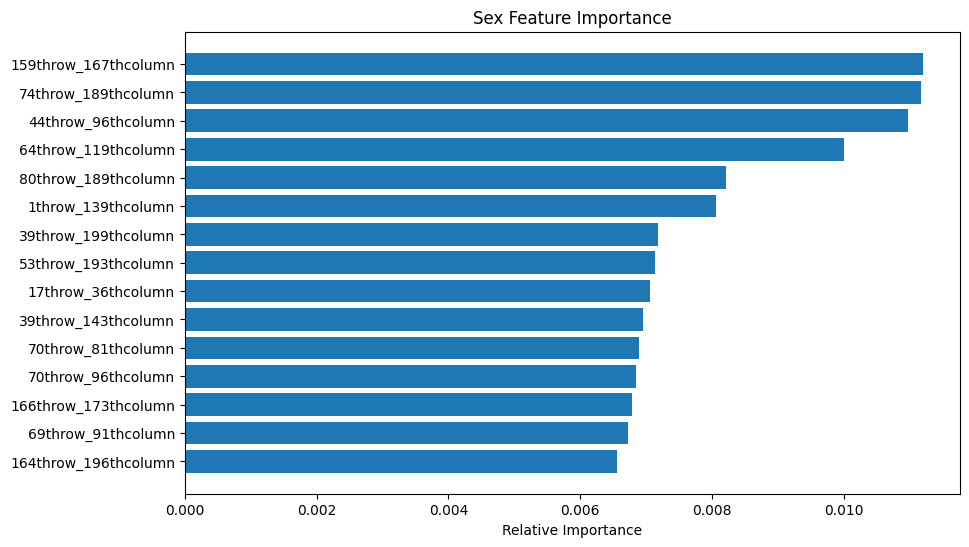


Final Model Metrics Summary:
  Model  Accuracy  F1-Score
0  ADHD    0.8230    0.8132
1   Sex    0.6914    0.6642


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_selection import SelectKBest, f_classif

# ========== 1. Prepare Targets ==========
sex_mapping = {'Male': 1, 'M': 1, 'Female': 0, 'F': 0, 1: 1, 0: 0}
y = pd.DataFrame({
    'ADHD': train_df['ADHD_Outcome'].astype(int),
    'Sex': train_df['Sex_F'].map(sex_mapping).astype(int)
})

# ========== 2. Prepare Features ==========
X = train_df.drop(columns=['ADHD_Outcome', 'Sex_F', 'participant_id'], errors='ignore')

# ========== 3. Reduce to Top 500 Features using ADHD relevance ==========
selector = SelectKBest(score_func=f_classif, k=500)
X_selected = selector.fit_transform(X, y['ADHD'])
selected_feature_indices = selector.get_support(indices=True)
selected_feature_names = X.columns[selected_feature_indices].tolist()

# ========== 4. Train-Test Split ==========
X_train, X_val, y_train, y_val = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# ========== 5. Evaluation Function ==========
def evaluate_model(y_true, y_pred, label):
    acc = accuracy_score(y_true, y_pred)
    f1 = classification_report(y_true, y_pred, output_dict=True)['weighted avg']['f1-score']
    print(f"{label} → Accuracy: {acc:.4f}, F1 Score: {f1:.4f}")
    return acc, f1

# ========== 6. Plot Feature Importance ==========
def plot_feature_importance(model, feature_names, title):
    importance = model.feature_importances_
    indices = np.argsort(importance)[-15:]
    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.barh(range(len(indices)), importance[indices], align='center')
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()

# ========== 7. Optimized Hyperparameter Grid ==========
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [3, 4],
    'learning_rate': [0.08, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0],
    'reg_alpha': [0, 0.1],
    'reg_lambda': [1, 2]
}

# ========== 8. ADHD Model ==========
adhd_model = RandomizedSearchCV(
    estimator=XGBClassifier(tree_method='hist', use_label_encoder=False, eval_metric='logloss', random_state=42),
    param_distributions=param_grid,
    n_iter=10,
    scoring='f1_weighted',
    cv=3,
    verbose=1,
    n_jobs=-1
)
adhd_model.fit(X_train, y_train['ADHD'])

# ========== 9. Sex Model ==========
sex_model = RandomizedSearchCV(
    estimator=XGBClassifier(tree_method='hist', use_label_encoder=False, eval_metric='logloss', random_state=42),
    param_distributions=param_grid,
    n_iter=10,
    scoring='f1_weighted',
    cv=3,
    verbose=1,
    n_jobs=-1
)
sex_model.fit(X_train, y_train['Sex'])

# ========== 10. Evaluate ==========
adhd_best = adhd_model.best_estimator_
sex_best = sex_model.best_estimator_

adhd_pred = adhd_best.predict(X_val)
sex_pred = sex_best.predict(X_val)

adhd_acc, adhd_f1 = evaluate_model(y_val['ADHD'], adhd_pred, "ADHD")
sex_acc, sex_f1 = evaluate_model(y_val['Sex'], sex_pred, "Sex")

# ========== 11. Plot Feature Importance ==========
plot_feature_importance(adhd_best, selected_feature_names, "ADHD Feature Importance")
plot_feature_importance(sex_best, selected_feature_names, "Sex Feature Importance")

# ========== 12. Summary ==========
summary = pd.DataFrame({
    'Model': ['ADHD', 'Sex'],
    'Accuracy': [adhd_acc, sex_acc],
    'F1-Score': [adhd_f1, sex_f1]
})
print("\nFinal Model Metrics Summary:")
print(summary.round(4))


Fitting 3 folds for each of 20 candidates, totalling 60 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:36:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



✅ [Sex Classifier]
Accuracy: 0.7531
F1-Score: 0.7466


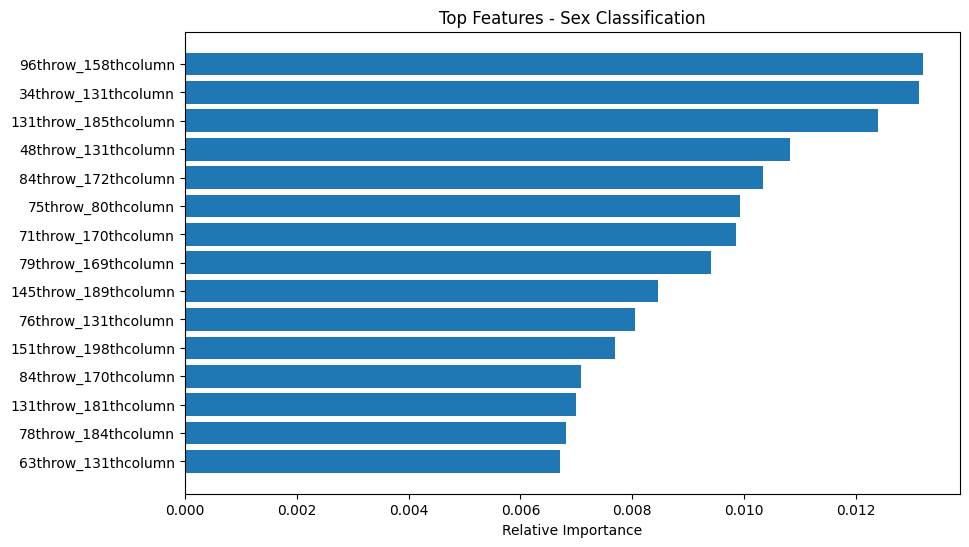

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils.class_weight import compute_class_weight

# ========== 1. Load Data (Update path if needed) ==========


# ========== 2. Prepare Target ==========
sex_mapping = {'Male': 1, 'M': 1, 'Female': 0, 'F': 0, 1: 1, 0: 0}
y_sex = train_df['Sex_F'].map(sex_mapping).astype(int)

# ========== 3. Prepare Features ==========
X = train_df.drop(columns=['ADHD_Outcome', 'Sex_F', 'participant_id'], errors='ignore')

# ========== 4. Feature Selection for Sex ==========
selector_sex = SelectKBest(score_func=f_classif, k=500)
X_sex_selected = selector_sex.fit_transform(X, y_sex)
sex_features = X.columns[selector_sex.get_support(indices=True)].tolist()

# ========== 5. Train-Test Split ==========
X_train_sex, X_val_sex, y_train_sex, y_val_sex = train_test_split(X_sex_selected, y_sex, test_size=0.2, random_state=42)

# ========== 6. Class Weights ==========
classes = np.unique(y_sex)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_sex)
scale_pos_weight = weights[1] / weights[0]

# ========== 7. Hyperparameter Grid ==========
sex_param_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.05, 0.08, 0.1, 0.12],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [1, 2, 3]
}

# ========== 8. Model Tuning ==========
sex_model = RandomizedSearchCV(
    estimator=XGBClassifier(
        tree_method='hist',
        use_label_encoder=False,
        eval_metric='logloss',
        scale_pos_weight=scale_pos_weight,
        random_state=42
    ),
    param_distributions=sex_param_grid,
    n_iter=20,
    scoring='f1_weighted',
    cv=3,
    verbose=1,
    n_jobs=-1
)

sex_model.fit(X_train_sex, y_train_sex)

# ========== 9. Evaluation ==========
sex_best = sex_model.best_estimator_
sex_pred = sex_best.predict(X_val_sex)

acc = accuracy_score(y_val_sex, sex_pred)
f1 = classification_report(y_val_sex, sex_pred, output_dict=True)['weighted avg']['f1-score']

print("\n✅ [Sex Classifier]")
print(f"Accuracy: {acc:.4f}")
print(f"F1-Score: {f1:.4f}")

# ========== 10. Feature Importance Plot ==========
def plot_feature_importance(model, feature_names, title):
    importances = model.feature_importances_
    indices = np.argsort(importances)[-15:]
    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.barh(range(len(indices)), importances[indices], align='center')
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
    plt.xlabel("Relative Importance")
    plt.show()

plot_feature_importance(sex_best, sex_features, "Top Features - Sex Classification")


In [ ]:
# ======= Load Test Data ========
#test_df = pd.read_csv("test.csv")

# Drop ID column for features
X_test_raw = test_df.drop(columns=['participant_id'], errors='ignore')

# ✅ Align columns with training features
X_test = X_test_raw[X.columns]  # Ensure same order and columns as training

# Apply SelectKBest from training
X_test_adhd = selector.transform(X_test)
X_test_sex = selector_sex.transform(X_test)

# Predict
adhd_test_pred = adhd_best.predict(X_test_adhd)
sex_test_pred = sex_best.predict(X_test_sex)

# ✅ Confirm shape match
assert len(adhd_test_pred) == len(test_df), "Mismatch in ADHD prediction length"
assert len(sex_test_pred) == len(test_df), "Mismatch in Sex prediction length"

# Final Submission DataFrame
submission_df = pd.DataFrame({
    'participant_id': test_df['participant_id'],
    'ADHD_Outcome': adhd_test_pred,
    'Sex_F': sex_test_pred
})

# Save to file
submission_df.to_csv("final_predictions.csv", index=False)

print("✅ Saved to final_predictions.csv")


✅ Saved to final_predictions.csv


<Figure size 600x400 with 0 Axes>

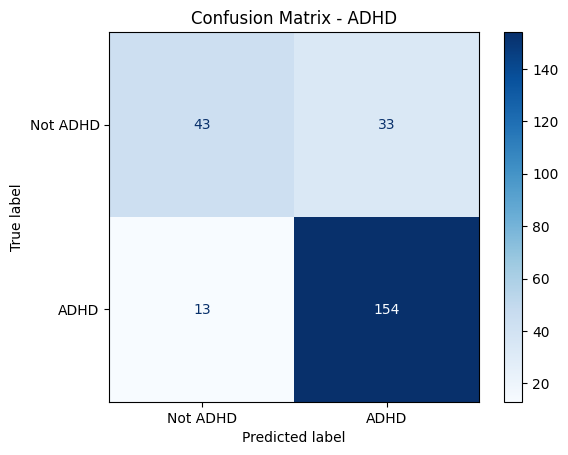

<Figure size 600x400 with 0 Axes>

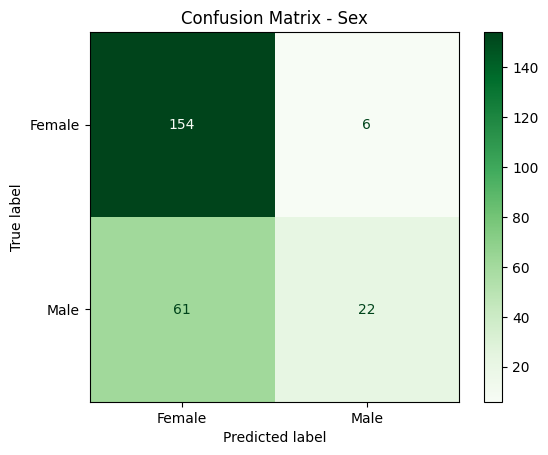

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# ADHD Confusion Matrix
adhd_cm = confusion_matrix(y_test['ADHD'], adhd_pred)
adhd_disp = ConfusionMatrixDisplay(confusion_matrix=adhd_cm, display_labels=['Not ADHD', 'ADHD'])
plt.figure(figsize=(6, 4))
adhd_disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix - ADHD")
plt.grid(False)
plt.show()

# Sex Confusion Matrix
sex_cm = confusion_matrix(y_test['Sex'], sex_pred)
sex_disp = ConfusionMatrixDisplay(confusion_matrix=sex_cm, display_labels=['Female', 'Male'])
plt.figure(figsize=(6, 4))
sex_disp.plot(cmap='Greens', values_format='d')
plt.title("Confusion Matrix - Sex")
plt.grid(False)
plt.show()
